# MAT-3: Markov chain Monte-Carlo 

## 0. Package installation & importing

In [1]:
install.packages(c("cowplot", "MASS", "ggplot2", "codetools", "tidyr", "devtools", "mcmcse", "plotly", "rgl", "pracma", "matrixStats"))

also installing the dependencies ‘systemfonts’, ‘textshaping’, ‘ragg’, ‘pkgdown’




In [1]:
library(MASS)
library(mvtnorm)
library(ggplot2)
library(codetools)
library(R6)
library(tidyr)
library(dplyr)
library(mcmcse)
library(plotly)
library(scatterplot3d)
library(matrixStats)
library(cowplot)

Warning message:
“package ‘mvtnorm’ was built under R version 4.2.0”
Warning message:
“package ‘R6’ was built under R version 4.2.0”
Warning message:
“package ‘dplyr’ was built under R version 4.2.0”

Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘mcmcse’ was built under R version 4.2.0”

Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Warning message:
“package ‘scatterplot3d’ was built under R version 4.2.0”

Attaching package: ‘matrixStats’


The following object is masked from ‘package:dpl

## 1. Methodology

### 1.1. Metropolis-Hastings

In [2]:
MHS <- R6Class("MHS",
              public = list(
                  samples = NULL, niter = 1000, nburn = 3, burnin = FALSE, dim = NULL,
                  sigma = NULL, x0 = NULL, name="MHS",
                  target.prob = NULL, target.prob.log = NULL,
                  
                  initialize = function(f, f.log, f.log.grad, dim, niter = 1000, nburn = 3, 
                                        burnin=TRUE, x0, sigma, const, epsilon, nleaps) {
                      # fun::f          : target function
                      # fun::f.log      : log of target dunction
                      # fun::f.log.grad : gradient of log of target function
                      # bool::burnin    : flag specifies whether to use burnin or not 
                      # int::nburn      : number of burnin iterations
                      # char[float]::x0 : starting point
                      # int::niter      : number of iterations (default = 1000)
                      # float::const    : not used (for UI compatibility reasons with RS)
                      # int::nleaps     : not used (for UI compatibility reasons with HMC)

                      if (missing(f)) stop("Target undefined")
                      self$target.prob <- f
                      if (missing(f.log)) stop("Target log undefined")
                      self$target.prob.log <- f.log
                      if (missing(dim)) stop("Dimensions undefined")
                      self$dim <- dim
                      if (missing(sigma)){
                          self$sigma <- diag(dim)
                      }else self$sigma <- sigma
                      if (missing(x0)) self$x0 <- rnorm(dim, sd = 5)
                      else self$x0 <- x0
                      if (!missing(niter)) self$niter <- niter
                      self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1)
                      self$burnin <- burnin
                      self$nburn <- nburn
                  },
                  proposal = function(x){ # normal proposal centered at zero with 2.4^2 * var / dim
                      return(rmvnorm(1, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim))
                  },
                  proposal.prob = function(x){ # normal density centered at zero with 2.4^2 * var / dim
                      return(dmvnorm(x=x, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim))
                  },
                  proposal.prob.log = function(x){ # log normal density
                      return(log(dmvnorm(x=c(x), mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim)))
                  },
                  sample_loop = function(){
                      p0 <- self$x0
                      p <- p0
                      
                      start.time <- Sys.time()
                      for (i in 1:self$niter){
                          p <- self$proposal(p) # propose

                          p_prob.log <- self$proposal.prob.log(p) # calculate likelihood proposal (p)
                          t_prob.log <- self$target.prob.log(p) # calculate likelihood target (p)

                          p0_prob.log <- self$proposal.prob.log(p0) # calculate likelihood proposal (p0)
                          t0_prob.log <- self$target.prob.log(p0) # calculate likelihood target (p0)
                          
                          logr <- (t_prob.log - p_prob.log) - (t0_prob.log - p0_prob.log) # log acceptance ratio
                          
                          if (is.nan(logr)) next # if both numerator and divisor inf (continue)
                          
                          if (log(runif(1)) < logr) p0 <- p # accept point with likelihood r
                          curr.time <- Sys.time() # measure time (diagnostics)
                          self$samples[i,] <- c(curr.time - start.time, p0) # save sample 
                      }
                      return(self$samples)
                  },                  
                  sample = function(){
                      if (self$burnin){
                          for (i in 1:self$nburn){
                              S_b <- self$sample_loop() # sample loop
                              # if empty cov : use default covariance matrix (all point rejected)
                              if (sum(rowAlls(is.na(S_b))) >= self$niter - 1){
                                print("BURNIN TUNNING failed (MHS)")
                                break
                              }
                              self$sigma <- cov(S_b[,2:ncol(S_b)], use="complete.obs") # update covariance using burnin
                              
                              # if covariance smaller than one (we don't want to small covariance than scale to 1)
                              if (all(self$sigma < 1)){
                                  if (all(self$sigma < 1) == 1) self$sigma <- diag(self$dim)
                                  self$sigma <- self$sigma / max(abs(self$sigma))
                              }
                          }
                          self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1)  # clear burn-in samples (keep covariance and starting point)
                      }                    
                      
                      return(self$sample_loop())
                  }
              ))

### 1.2. HMC

In [3]:
first_nan <- NULL
h0 <- NULL
h1 <- NULL
plog_tmp <- NULL
p_tmp <- NULL
plog <- NULL
prop <- NULL
x_tmp <- NULL
hpx <- NULL

HMC <- R6Class("HMC",
              public = list(
                  samples = NULL, niter = 1000, nburn = 1, burnin = FALSE, dim = NULL,
                  sigma = NULL, x0 = NULL, name="HMC",
                  target.prob = NULL, target.prob.log = NULL, target.prob.log.grad = NULL,
                  nleaps = 10, momentum = NULL, m0 = NULL, mL = NULL, eps = 1,
                  
                  initialize = function(f, f.log, f.log.grad, dim, niter, nburn = 1, burnin=TRUE, x0, sigma, const, epsilon, nleaps) {
                      # fun::f          : target function
                      # fun::f.log      : log of target dunction
                      # fun::f.log.grad : gradient of log of target function
                      # bool::burnin    : flag specifies whether to use burnin or not 
                      # int::nburn      : number of burnin iterations
                      # char[float]::x0 : starting point
                      # int::niter      : number of iterations (default = 1000)
                      # float::const    : not used (for UI compatibility reasons with RS)
                      # float::epsilon  : step size for gradient ascent
                      # int::nleaps     : number of steps in gradient direction to take before satisfied
                      
                      if (missing(f)) stop("Target undefined")
                      self$target.prob <- function(x) return(-f(x))
                      if (missing(f.log)) stop("Target log undefined")
                      self$target.prob.log <- function(x) return(-f.log(x))
                      if (missing(f.log.grad)) stop("Target gradient undefined")
                      self$target.prob.log.grad <- function(x) return(-f.log.grad(x))
                      if (missing(dim)) stop("Dimensions undefined")
                      self$dim <- dim
                      if (missing(sigma)){
                          self$sigma <- diag(dim)
                      }else self$sigma <- sigma
                      if (missing(x0)) self$x0 <- rnorm(dim, sd = 1)
                      else self$x0 <- x0
                      if (!missing(niter)) self$niter <- niter
                      self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1)
                      self$burnin <- burnin
                      self$nburn <- nburn
                      if (!missing(epsilon)) self$eps <- epsilon
                      if (!missing(nleaps)) self$nleaps <- nleaps
                  },
                  proposal = function(x){
                      # generate proposal given x (similar to GD using momentum)

                      # generate random starting momentum m0
                      p <- t(rmvnorm(1, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim)) 
                      self$m0 <- p 
                      
                      # repeat for nleaps
                      for (i in 1:self$nleaps){
                          x_p0 <- x # x0 (from prev. iteration)
                          
                          p <- p - 0.5 * self$eps * self$target.prob.log.grad(x) # update mommentum using matrix
                          x <- x + self$eps * solve(self$sigma) %*% p # update x
                          p <- p - 0.5 * self$eps * self$target.prob.log.grad(x) # update mommentum using matrix
                          # better estimate if we split mommentum updates into two 
                          
                          # REMOVE AFTER DONE
                          #if (any(is.nan(x)) & is.null(first_nan)) {
                          #    print("HELLO, WORLD")
                          #    print(x_p0)
                          #}
                      }
                      self$mL <- p # save end momentum mL
                      
                      return(x)
                  },
                  hamiltonian = function(x, p){
                      plog_tmp <<- self$target.prob.log(x)
                      p_tmp <<- p
                      x_tmp <<- x
                      # calculate hamiltonian prob of moving from point x in direction p
                      return(self$target.prob.log(x) + 0.5 * t(p) %*% solve(self$sigma) %*% p)
                  },
                  sample_loop = function(){
                      p0 <- t(t(self$x0)) # change x0 so its a matrix
                      p <- p0 
                      
                      start.time <- Sys.time()
                      for (i in 1:self$niter){
                          p <- self$proposal(p) # generate proposal
                          
                          logr <- self$hamiltonian(p0, self$m0) - self$hamiltonian(p, self$mL) # acceptance ratio is diff of hamiltonians
                          
                          # both hamiltonians infinity -> ignore
                          if (is.nan(logr)){
                              if (is.null(first_nan)){ 
                                  first_nan <<- i
                                  h0 <<- self$hamiltonian(p0, self$m0)
                                  h1 <<- self$hamiltonian(p, self$mL)
                                  plog <<- plog_tmp
                                  prop <<- p_tmp
                                  hpx <<- x_tmp
                              }
                              # randomly sample: reinitialize
                              next
                          }
                          
                          if (log(runif(1)) < logr) p0 <- p # accept with probability r
                          curr.time <- Sys.time() # log time (diagnostics)
                          self$samples[i,] <- c(curr.time - start.time, p0)
                      }
                      return(self$samples)
                  },                  
                  sample = function(){
                      if (self$burnin){
                          for (i in 1:self$nburn){
                              S_b <- self$sample_loop()
                              # if empty cov : use default covariance matrix (all point rejected)
                              if (sum(rowAlls(is.na(S_b))) >= self$niter - 1){
                                print("BURNIN TUNNING failed (HMC)")
                                break
                              }
                              self$sigma <- cov(S_b[,2:ncol(S_b)], use="complete.obs") # update covariance using burnin
                              
                              # if covariance smaller than one (we don't want to small covariance than scale to 1)
                              if (all(self$sigma < 1)){
                                  if (all(self$sigma < 1) == 1) self$sigma <- diag(self$dim)
                                  self$sigma <- self$sigma / max(abs(self$sigma))
                              }
                          }
                          self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1) # clear burn-in samples (keep covariance and starting point)
                      }                    
                      
                      return(self$sample_loop()) 
                  }
              ))

### 1.3. Rejection sampling

In [4]:
RS <- R6Class("RS",
              public = list(
                  samples = NULL, niter = 1000, nburn = 3, burnin = FALSE, dim = NULL,
                  sigma = NULL, x0 = NULL, name="RS",
                  target.prob = NULL, target.prob.log = NULL, M = NULL,
                  
                  initialize = function(f, f.log, f.log.grad, dim, niter, burnin=TRUE, nburn= 3, x0, sigma, const, epsilon, nleaps) {
                      # fun::f          : target function
                      # fun::f.log      : log of target dunction
                      # fun::f.log.grad : gradient of log of target function
                      # bool::burnin    : flag specifies whether to use burnin or not 
                      # int::nburn      : number of burnin iterations
                      # char[float]::x0 : starting point
                      # int::niter      : number of iterations (default = 1000)
                      # float::const    : const M that tells us how large our envelope needs to be
                      # int::nleaps     : not used (for UI compatibility reasons with HMC)
                      if (missing(f)) stop("Target undefined")
                      self$target.prob <- f
                      if (missing(f.log)) stop("Target log undefined")
                      self$target.prob.log <- f.log
                      if (missing(dim)) stop("Dimensions undefined")
                      self$dim <- dim
                      if (missing(sigma)){
                          self$sigma <- diag(dim)
                      }else self$sigma <- sigma
                      if (missing(const)) self$M <- 0
                      else self$M <- log(const)
                      if (missing(x0)) self$x0 <- rnorm(dim, sd = 5)
                      else self$x0 <- x0
                      if (!missing(niter)) self$niter <- niter
                      self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1)
                      self$burnin <- burnin
                      self$nburn <- nburn
                  },
                  proposal = function(x){ # normal proposal centered at zero with 2.4^2 * var / dim
                      return(rmvnorm(1, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim))
                  },
                  proposal.prob = function(x){ # normal density centered at zero with 2.4^2 * var / dim
                      return(dmvnorm(x=x, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim))
                  },
                  proposal.prob.log = function(x){ # log normal density
                      return(log(dmvnorm(x=x, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim)))
                  },
                  sample_loop = function(){
                      p <- self$x0
                      
                      start.time <- Sys.time()
                      for (i in 1:self$niter){
                          # generate proposal
                          p <- self$proposal(p)

                          # calculate target/proposal likelihood of moving to p
                          p_prob.log <- self$proposal.prob.log(p)
                          t_prob.log <- self$target.prob.log(p)
                          
                          # acceptance ratio with M(const) a linear shift (functions as envelope)
                          logr <- (t_prob.log - p_prob.log - self$M)
                          
                          if (is.nan(logr)) next
                          
                          if (log(runif(1)) > logr) next # accept in accordance to ratio
                          curr.time <- Sys.time() # log time (diagnostics)
                          self$samples[i,] <- c(curr.time - start.time, p) # save sample
                      }
                      return(self$samples)
                  },                  
                  sample = function(){
                      if (self$burnin){
                          for (i in 1:self$nburn){
                              S_b <- self$sample_loop()
                              # if empty cov : use default covariance matrix (all point rejected)
                              if (sum(rowAlls(is.na(S_b))) >= self$niter - 1){ 
                                print("BURNIN TUNNING failed (RS)")
                                break
                              }
                              self$sigma <- cov(S_b[,2:ncol(S_b)], use="complete.obs") # update covariance using burnin
                          }
                          self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1)  # clear burn-in samples (keep covariance and starting point)
                      }                    
                      
                      return(self$sample_loop())
                  }
              ))

### 1.4. Plots

In [69]:
# SHOULD I USE MEAN: DECREASES VARIANCE
traceplot <- function(df, bnds=c(-4.5, 4.5)){
    tf <- tibble(df)
    xlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(xlen))
    # print(xlen)
    tf <- gather(df, key = "param", value = "d", xcols)
    tf["tune"][tf$tune, ] <- "tuned"
    tf["tune"][tf$tune != "tuned", ] <- "~tuned"
    rf <- tf %>% group_by(across(all_of(c("alg", "run", "iter", "tune", "param")))) %>% 
                 summarise_at(vars("d"), list(d = mean))
    # print(head(rf))
    # show only largest and smallest xvalues and middle
    # TODO: if neccesarry
    g <- ggplot(rf, aes(x=iter, y=d, group=param)) + geom_line(aes(color=param), alpha=.4)
    g <- g + theme(legend.position=c(.93,.48),
                aspect.ratio=0.5,
                legend.direction = "horizontal",
                legend.box = "horizontal",
                legend.key.size = unit(0.16, "cm"),
                legend.title=element_blank(),
                legend.margin=margin(c(1,1,1,1))) + 
             coord_cartesian(ylim=bnds) +
             facet_wrap(~tune + alg, nrow=2)
    
    return(list("g" = g, "df" = rf))
}

# autocorrelation
autocorr <- function(df, bnds=c(-0.05, 0.4)){
    dlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(dlen))
    lcols <- paste0(rep("lag_x"), seq(dlen))
    rf <- data.frame(matrix(ncol=2 * dlen + 2, nrow=0))
    colnames(rf) <- c("alg", "tune", "var", "lag", "val")
    for (a in unique(df$alg)){
            for (t in unique(df$tune)){
                for (xcol in xcols){
                    for (i in 1:5){
                        plt <- acf(df[(df$run == i) & (df$alg == a) & (df$tune == t), xcol], lag.max = 100, na.action=na.pass, plot = FALSE)
                        for (j in c(1)){
                            for (k in c(1)){
                                cbplt <- cbind(plt$lag[,k,j], plt$acf[,k,j])
                                rf <- rbind(rf, cbind(matrix(rep(a, dim(cbplt)[1]), ncol = 1), matrix(rep(t, dim(cbplt)[1]), ncol = 1), matrix(rep(xcol, dim(cbplt)[1]), ncol = 1), cbplt))
                            }
                        }                
                    }
                }
            }
    }
    if (dlen == 2)
        dnrow <- 2
    else
        dnrow <- 4
    colnames(rf) <- c("alg", "tune", "var", "lag", "val")
    rf <- transform(rf, tune = as.logical(tune), lag = as.numeric(lag), val = as.numeric(val))
    gf <- aggregate(. ~ alg+tune+var+lag, data=rf, FUN=mean)
    gf <- rf[rf$lag > 0,]
    gf[,"lag"] <- ceiling(gf$lag / 10) * 10
    gf_sd <- aggregate(. ~ alg+tune+var+lag, data=gf, FUN=function(x) return(sqrt(var(x))))
    gf <- aggregate(. ~ alg+tune+var+lag, data=gf, FUN=mean)
    gf[, "sd"] <- gf_sd$val
    gf["tune"][gf$tune, ] <- "tuned"
    gf["tune"][gf$tune != "tuned", ] <- "~tuned"
    g <- ggplot(data=gf, aes(x=lag, y=val, fill=alg)) +
         geom_bar(stat="identity", position=position_dodge(7), width=7) +
         geom_errorbar(aes(ymin=val-sd, ymax=val+sd), width=.1, position=position_dodge(7)) +
         coord_cartesian(ylim=bnds) +
         theme(legend.position=c(.79,.4),
                aspect.ratio=1, legend.direction = "horizontal", legend.box = "horizontal") + 
         facet_wrap(~tune+var, nrow=dnrow)
    
    return(list("g" = g, "df" = gf))
}

# ESS
wess <- function(df){
    df <- na.omit(df)
    dlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(dlen))
    rf <- data.frame(matrix(ncol=dlen + 2, nrow=0))
    colnames(rf) <- c("alg", "tune", xcols)
    rf["tune"][rf$tune, ] <- "tuned"
    rf["tune"][rf$tune != "tuned", ] <- "~tuned"

    dlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(dlen))
    rf <- data.frame(matrix(ncol=dlen, nrow=0))
    colnames(rf) <- xcols

    for (a in unique(df$alg)){
        for (t in unique(df$tune)){
            for (i in 1:5){
                ess_i <- ess(df[(df$run == i) & (df$alg == a) & (df$tune == t), xcols])
                ess_i <- c(a, t, ess_i)
                rf <- rbind(rf, ess_i)
            }
        }
    }
    colnames(rf) <- c("alg", "tune", xcols)
    mu_rf <- aggregate(. ~ alg + tune, data=rf, FUN=function(x) mean(as.numeric(x)))
    std_rf <- aggregate(. ~ alg + tune, data=rf, FUN=function(x) sqrt(var(as.numeric(x))))
    rf <- cbind(mu_rf, std_rf[, xcols])
                        
    return(rf[order(apply(rf[,xcols], 1, FUN=sum)),])
} 

# ESS per second
wesssec <- function(df){
    df <- na.omit(df)
    dlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(dlen))
    rf <- data.frame(matrix(ncol=dlen + 2, nrow=0))
    colnames(rf) <- c("alg", "tune", xcols)

    dlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(dlen))
    rf <- data.frame(matrix(ncol=dlen, nrow=0))
    colnames(rf) <- xcols

    for (a in unique(df$alg)){
        for (t in unique(df$tune)){
            for (i in 1:5){
                idf <- df[df$run == i, c("time", xcols)]
                ess_i <- ess(df[(df$run == i) & (df$alg == a) & (df$tune == t), xcols])
                ess_i <- c(a, t, ess_i / max(idf$time))
                rf <- rbind(rf, ess_i)
            }
        }
    }
    colnames(rf) <- c("alg", "tune", xcols)
    mu_rf <- aggregate(. ~ alg + tune, data=rf, FUN=function(x) mean(as.numeric(x)))
    std_rf <- aggregate(. ~ alg + tune, data=rf, FUN=function(x) sqrt(var(as.numeric(x))))
    rf <- cbind(mu_rf, std_rf[, xcols])
    
    return(rf[order(apply(rf[,xcols], 1, FUN=sum)),])
}
                        
# convergence plot
converge_plot <- function(df, mu, bnds=c(-0.05, 3)){
    dlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(dlen))
    idf <- data.frame(matrix(ncol = 4 + dlen, nrow = 0))
    df <- df[order(df$iter),]
    df["tune"][df$tune, ] <- "tuned"
    df["tune"][df$tune != "tuned", ] <- "~tuned"
    for (a in unique(df$alg)){
            for (r in unique(df$run)){
                for (tn in unique(df$tune)){
                    i_ind <- (df$alg == a) & (df$run == r) & (df$tune == tn)
                    tmp <- df[i_ind,]
                    # print(head(tmp))
                    csum <- matrix(NA, nrow=dim(tmp)[1], ncol=dlen)
                    sum <- rep(0, dlen)
                    dist <- c()
                    for(i in 1:dim(tmp)[1]){
                        cm <- as.numeric(tmp[i, xcols])
                        if (all(!is.na(cm))){
                            sum <- sum + cm
                        }
                        csum[i,] <- sum / i
                        dist <- c(dist, sqrt(sum((sum / i - mu)^2)))
                    }
                    # print(dim(csum))
                    ix <- cbind(a, r, tn, 1:dim(tmp)[1], csum, dist)
                    # print(head(ix))
                    idf <- rbind(idf, ix)
                    csum <- NULL
                }
            }
        }
    colnames(idf) <- c("alg", "run", "tune", "iter", xcols, "dist")
    idf[, c("iter", xcols, "dist")] <- sapply(idf[, c("iter", xcols, "dist")],as.numeric)
    idf <- idf %>% group_by(alg, tune, iter) %>% summarise_at(c(xcols, "dist"), .funs=c(mean, sd))
    colnames(idf) <- c("alg", "tune", "iter", paste0("mu_", c(xcols, "dist")), paste0("sd_", c(xcols, "dist")))
    g <- ggplot(idf, aes(x=iter, y=mu_dist, colour=alg)) + geom_line() +
            geom_errorbar(aes(ymin=mu_dist-sd_dist, ymax=mu_dist+sd_dist), width=.1, position=position_dodge(5), alpha=0.05) +
            coord_cartesian(ylim=bnds) +
            theme(legend.position=c(.9,.75), aspect.ratio=1) + 
            facet_wrap(~tune)
    
    return(list("g" = g, "df" = idf))
}

### 1.5 Analysis

In [23]:
generate_results <- function(name, f, f.log, f.log.grad, f.samplers, dim=2){
    xlen <- dim
    xcols <- paste0(rep("x"), seq(xlen))
    df <- data.frame(matrix(ncol = 5 + dim, nrow = 0))
    colnames(df) <- c("alg", "tune", "run", "iter", "time", xcols)
    niter <- 1000

    # for method in methodology
    for (f.sampler in f.samplers){
        # repeat n-times for uncertainty estimation
        for (i in 1:5) {
            # extract parameters
            obj <- f.sampler[["sampler"]]
            niter <- f.sampler[["niter"]]
            burnin <- f.sampler[["burnin"]]
            nburn <- f.sampler[["nburn"]]
            epsilon <- f.sampler[["epsilon"]]
            nleaps <- f.sampler[["nleaps"]]
            const <- f.sampler[["const"]]
            sigma <- f.sampler[["sigma"]]

            if(is.null(dim(sigma))) sigma <- sigma[[1]] # expand grid sigma

            # run sampler
            sampler <- obj$new(f = f, f.log = f.log, f.log.grad = f.log.grad, dim = dim, niter = niter,
                                 burnin = burnin,
                                 nburn = nburn,
                                 epsilon = epsilon,
                                 nleaps = nleaps,
                                 const = const, 
                                 sigma = sigma)
            tp <- sampler$sample()
            df_nsamp <- data.frame(tp)
            colnames(df_nsamp) <- c("time", xcols)
            df_nsamp$iter <- seq(niter)
            df_nsamp$alg <- sampler$name
            df_nsamp$tune <- burnin
            df_nsamp$run <- i
            df <- rbind(df, df_nsamp)
        }
    }
    write.csv(df, paste("./table/df-", name, ".csv")) 
    
    return(df)
}

present_results <- function(df, name, keypoints, bnds=list("cvg"=c(-0.05, 3))){
    # check whether shape is correct
    g <- ggplot(df, aes(x=x1, y=x2, color = tune)) + geom_point()
    if (!is.null(keypoints)) 
        g <- g + geom_point(aes(x=keypoints[1], y=keypoints[2]), colour="blue")
    plt <- g + facet_wrap(~tune+alg)
    print(plt)
    
    # plot convergence
    plt_list <- converge_plot(df, keypoints, bnds=bnds[["cvg"]])
    plt_df <- plt_list[["df"]]
    write.csv(plt_df, paste("./table/convergence-", name, ".csv"), row.names=TRUE)
    plt <- plt_list[["g"]]
    ggsave(paste("./img/", name, "_convergence.png"), plot = plt, dpi=100)
    print(plt)

    # plot traceplot
    options(repr.plot.width=15, repr.plot.height=8)
    plt_list <- traceplot(df, bnds=bnds[["tra"]])
    plt_df <- plt_list[["df"]]
    write.csv(plt_df, paste("./table/traceplot-", name, ".csv"), row.names=TRUE)
    plt <- plt_list[["g"]]
    ggsave(paste("./img/", name, "_traceplot.png"), plot = plt, dpi=100)
    print(plt)

    # plot autocorrelation
    plt_list <- autocorr(df, bnds=bnds[["acf"]])
    plt_df <- plt_list[["df"]]
    write.csv(plt_df, paste("./table/acf-", name, ".csv"), row.names=TRUE)
    plt <- plt_list[["g"]]
    ggsave(paste("./img/", name, "_acf.png"), plot = plt, dpi=100)
    print(plt)


    # calculate ESS
    ress <- wess(df)
    print("ESS")
    print(ress)
    write.csv(ress, paste("./table/ess-", name, ".csv"), row.names=TRUE) 

    # calculate ESS/second (maybe ESS per second)
    resssec <- wesssec(df)
    print("ESS/second")
    print(resssec)
    write.csv(resssec, paste("./table/esssec-", name, ".csv"), row.names=TRUE)
}

## 2. Results

In [24]:
construct.covmat.2d = function(s1, s2, ro){
    return(matrix(c(s1^2, ro * s1 * s2, ro * s1 * s2, s2^2), nrow = 2))
}

### 2.1. Bivariate Normal distribution

In [8]:
covmat <- diag(2)

bivar.prob = function(x){
    return(dmvnorm(x=c(x), mean=rep(0, 2), sigma=covmat))
}

bivar.prob.log = function(x){
    return(log(dmvnorm(x=c(x), mean=rep(0, 2), sigma=covmat)))
}

bivar.log.grad = function(x){
    return(-solve(covmat) %*% x)
}

#### 2.1.0 Hyperparameter search

In [82]:
# Grid for RS
rs.nburn <- c(0, 1, 3, 5)
rs.const <- c(1, exp(-10), exp(-100), exp(-500), exp(-800))
rs.covmat <- list(diag(2)) 

rs.params <- expand.grid(nburn=rs.nburn, const=rs.const, sigma=rs.covmat)
rs.params[, "mse"] <- NA

# Grid for MHS
mhs.nburn <- c(0, 1, 3, 5)
mhs.covmat <- list(diag(2)) 

mhs.params <- expand.grid(nburn=mhs.nburn, sigma=mhs.covmat)
mhs.params[, "mse"] <- NA

# Grid for HMC
hmc.nburn <- c(0, 1, 3, 5)
hmc.epsilon <- c(0.001, 0.01, 0.1, 1)
hmc.nleaps <- c(5, 10, 30)
hmc.covmat <- list(diag(2)) 

hmc.params <- expand.grid(nburn=hmc.nburn, sigma=hmc.covmat, nleaps=hmc.nleaps, epsilon=hmc.epsilon)
hmc.params[, "mse"] <- NA

# Hyperparameter search RS
if(nrow(rs.params) > 100) {
    niter = 100
}else {niter = nrow(rs.params)}

for(i in 1:niter) {
    if (is.na(rs.params[i,"mse"])){
        if(niter < nrow(rs.params)){ 
            ind <- round(runif(1, min = 1, max = nrow(rs.params)))
        }else {ind <- i} 
        row <- rs.params[ind,]
        bivar.params <- list(list("sampler"= RS,
                        "niter"=1000,
                        "burnin"=TRUE,
                        "nburn"=row$nburn,
                        "sigma"=row$sigma,
                        "epsilon"=0,
                        "nleaps"=0,
                        "const"=row$const))
        if (!file.exists(paste0("table/df- bivar-grid-rs- ", i ," .csv"))){
        df.bivar.grid <- generate_results(name = paste("bivar-grid-rs-", ind), f = bivar.prob,
                                        f.log = bivar.prob.log, f.log.grad = bivar.log.grad,
                                        f.samplers = bivar.params)
        }else{
            df.bivar.grid <- read.csv(paste0("table/df- bivar-grid-rs- ", i ," .csv"))
        }
        df.bivar.means <- df.bivar.grid %>% group_by(run) %>% summarise_at(vars(x1, x2), funs(mean(., na.rm=TRUE)))
        rs.params[ind,"mse"] <- sqrt(sum(colMeans(df.bivar.means[, c("x1", "x2")])^2))
    }
}
rs.params$sigma <- as.character(rs.params$sigma)
write.csv(rs.params, "bivar-rs-params.csv")

# Hyperparameter search MHS
if(nrow(mhs.params) > 100) {
    niter = 100
}else {niter = nrow(mhs.params)}

for(i in 1:niter) {
    if (is.na(mhs.params[i,"mse"])){
        if(niter < nrow(mhs.params)){
            ind <- round(runif(1, min = 1, max = nrow(mhs.params)))
        }else {ind <- i} 
        row <- mhs.params[ind,]
        bivar.params <- list(list("sampler"=MHS,
                        "niter"=1000,
                        "burnin"=TRUE,
                        "nburn"=row$nburn,
                        "sigma"=row$sigma,
                        "epsilon"=0,
                        "nleaps"=0,
                        "const"=0))
        if (!file.exists(paste0("table/df- bivar-grid-mhs- ", i ," .csv"))){
        df.bivar.grid <- generate_results(name = paste("bivar-grid-mhs-", ind), f = bivar.prob,
                                        f.log = bivar.prob.log, f.log.grad = bivar.log.grad,
                                        f.samplers = bivar.params)
        }else{
            df.bivar.grid <- read.csv(paste0("table/df- bivar-grid-mhs- ", i ," .csv"))
        }
        df.bivar.means <- df.bivar.grid %>% group_by(run) %>% summarise_at(vars(x1, x2), funs(mean(., na.rm=TRUE)))
        mhs.params[ind,"mse"] <- sqrt(sum(colMeans(df.bivar.means[, c("x1", "x2")])^2))
    }
}
mhs.params$sigma <- as.character(mhs.params$sigma)
write.csv(mhs.params, "bivar-mhs-params.csv")

# Hyperparameter search HMC
if(nrow(hmc.params) > 100) {
    niter = 100
}else {niter = nrow(hmc.params)}

for(i in 1:niter) {
    if (is.na(hmc.params[i,"mse"])){
        if(niter < nrow(hmc.params)){
            ind <- round(runif(1, min = 1, max = nrow(hmc.params)))
        }else {ind <- i} 
        row <- hmc.params[ind,]
        bivar.params <- list(list("sampler"=HMC,
                        "niter"=1000,
                        "burnin"=TRUE,
                        "nburn"=row$nburn,
                        "sigma"=row$sigma,
                        "epsilon"=row$epsilon,
                        "nleaps"=row$nleaps,
                        "const"=0))
        if (!file.exists(paste0("table/df- bivar-grid-hmc- ", i ," .csv"))){
        df.bivar.grid <- generate_results(name = paste("bivar-grid-hmc-", ind), f = bivar.prob,
                                        f.log = bivar.prob.log, f.log.grad = bivar.log.grad,
                                        f.samplers = bivar.params)
        }else{
            df.bivar.grid <- read.csv(paste0("table/df- bivar-grid-hmc- ", i ," .csv"))
        }
        df.bivar.means <- df.bivar.grid %>% group_by(run) %>% summarise_at(vars(x1, x2), funs(mean(., na.rm=TRUE)))
        hmc.params[ind,"mse"] <- sqrt(sum(colMeans(df.bivar.means[, c("x1", "x2")])^2))
    }
}
hmc.params$sigma <- as.character(hmc.params$sigma)
write.csv(hmc.params, "bivar-hmc-params.csv")

# find min parameters: run for those parameters
hmc.params <- hmc.params[order(hmc.params$mse), ]
mhs.params <- mhs.params[order(mhs.params$mse), ]
rs.params <- rs.params[order(rs.params$mse), ]

hmc.min.param <- hmc.params[1, ]
mhs.min.param <- mhs.params[1, ]
rs.min.param <- rs.params[1, ]

print("RS-hyperparams")
print(rs.min.param)
print(paste("mean diff: ", mean(rs.params$mse, na.rm = TRUE) - rs.min.param$mse))
print(paste("std: ", sqrt(var(rs.params$mse, na.rm = TRUE))))

print("MHS-hyperparams")
print(mhs.min.param)
print(paste("mean diff: ", mean(mhs.params$mse, na.rm = TRUE) - mhs.min.param$mse))
print(paste("std: ", sqrt(var(mhs.params$mse, na.rm = TRUE))))

print("HMC-hyperparams")
print(hmc.min.param)
print(paste("mean diff: ", mean(hmc.params$mse, na.rm = TRUE) - hmc.min.param$mse))
print(paste("std: ", sqrt(var(hmc.params$mse, na.rm = TRUE))))

[1] "RS-hyperparams"
  nburn const         sigma      mse
4     5     1 c(1, 0, 0, 1) 0.013153
[1] "mean diff:  0.0735442987822443"
[1] "std:  0.0864096899825043"
[1] "MHS-hyperparams"
  nburn         sigma        mse
1     0 c(1, 0, 0, 1) 0.02076393
[1] "mean diff:  0.00677779837145612"
[1] "std:  0.00522467369780201"
[1] "HMC-hyperparams"
   nburn         sigma nleaps epsilon         mse
34     1 c(1, 0, 0, 1)     30     0.1 0.009609274
[1] "mean diff:  0.344292569874999"
[1] "std:  0.333205738537697"


#### 2.1.1 Comparison

In [14]:
# specify parameters
bivar.params <- list(list("sampler"=RS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=FALSE,
                      "nburn"=0,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=1),
                     list("sampler"=RS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=TRUE,
                      "nburn"=rs.min.param$nburn,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=rs.min.param$const),
                     list("sampler"=MHS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=FALSE,
                      "nburn"=0,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=0),
                     list("sampler"=MHS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=TRUE,
                      "nburn"=mhs.min.param$nburn,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=0),
                     list("sampler"=HMC,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=FALSE,
                      "nburn"=0,
                      "epsilon"=1,
                      "nleaps"=10,
                      "const"=0),
                     list("sampler"=HMC,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=TRUE,
                      "nburn"=hmc.min.param$nburn,
                      "epsilon"=hmc.min.param$epsilon,
                      "nleaps"=hmc.min.param$nleaps,
                      "const"=0))

df.bivar <- generate_results(name = "bivar", f = bivar.prob, f.log = bivar.prob.log, f.log.grad = bivar.log.grad, f.samplers = bivar.params)

Warning message:
“Removed 4296 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



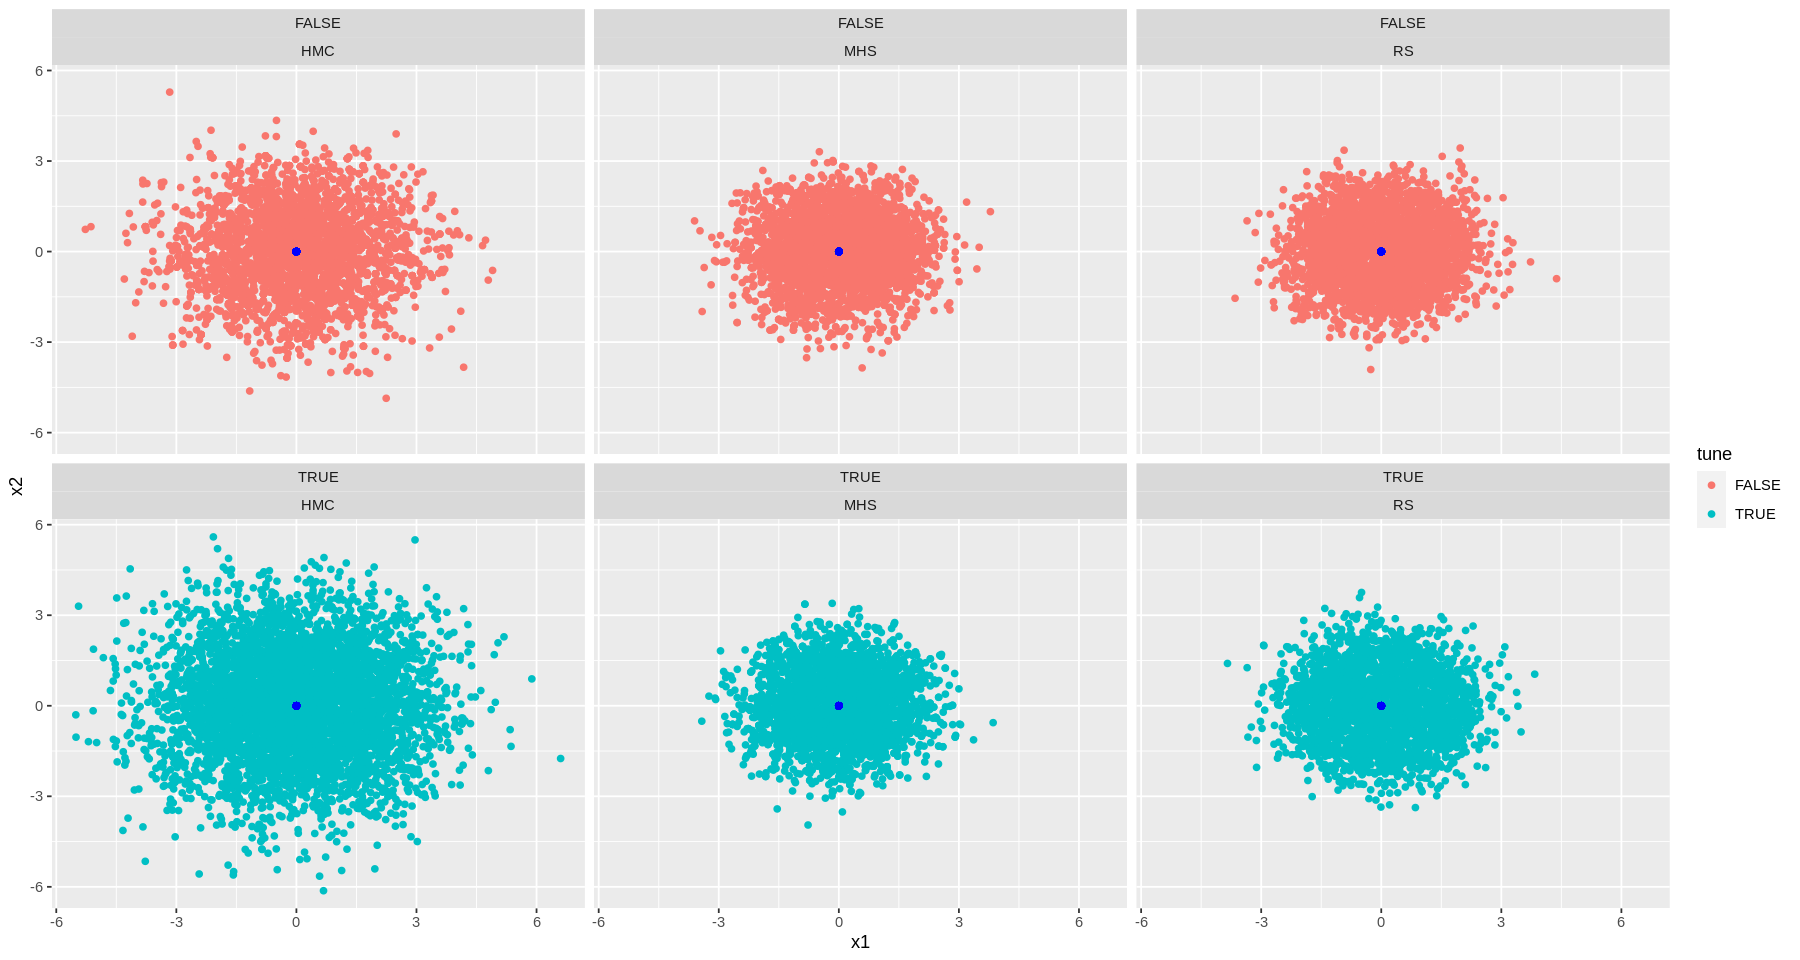

Saving 6.67 x 6.67 in image



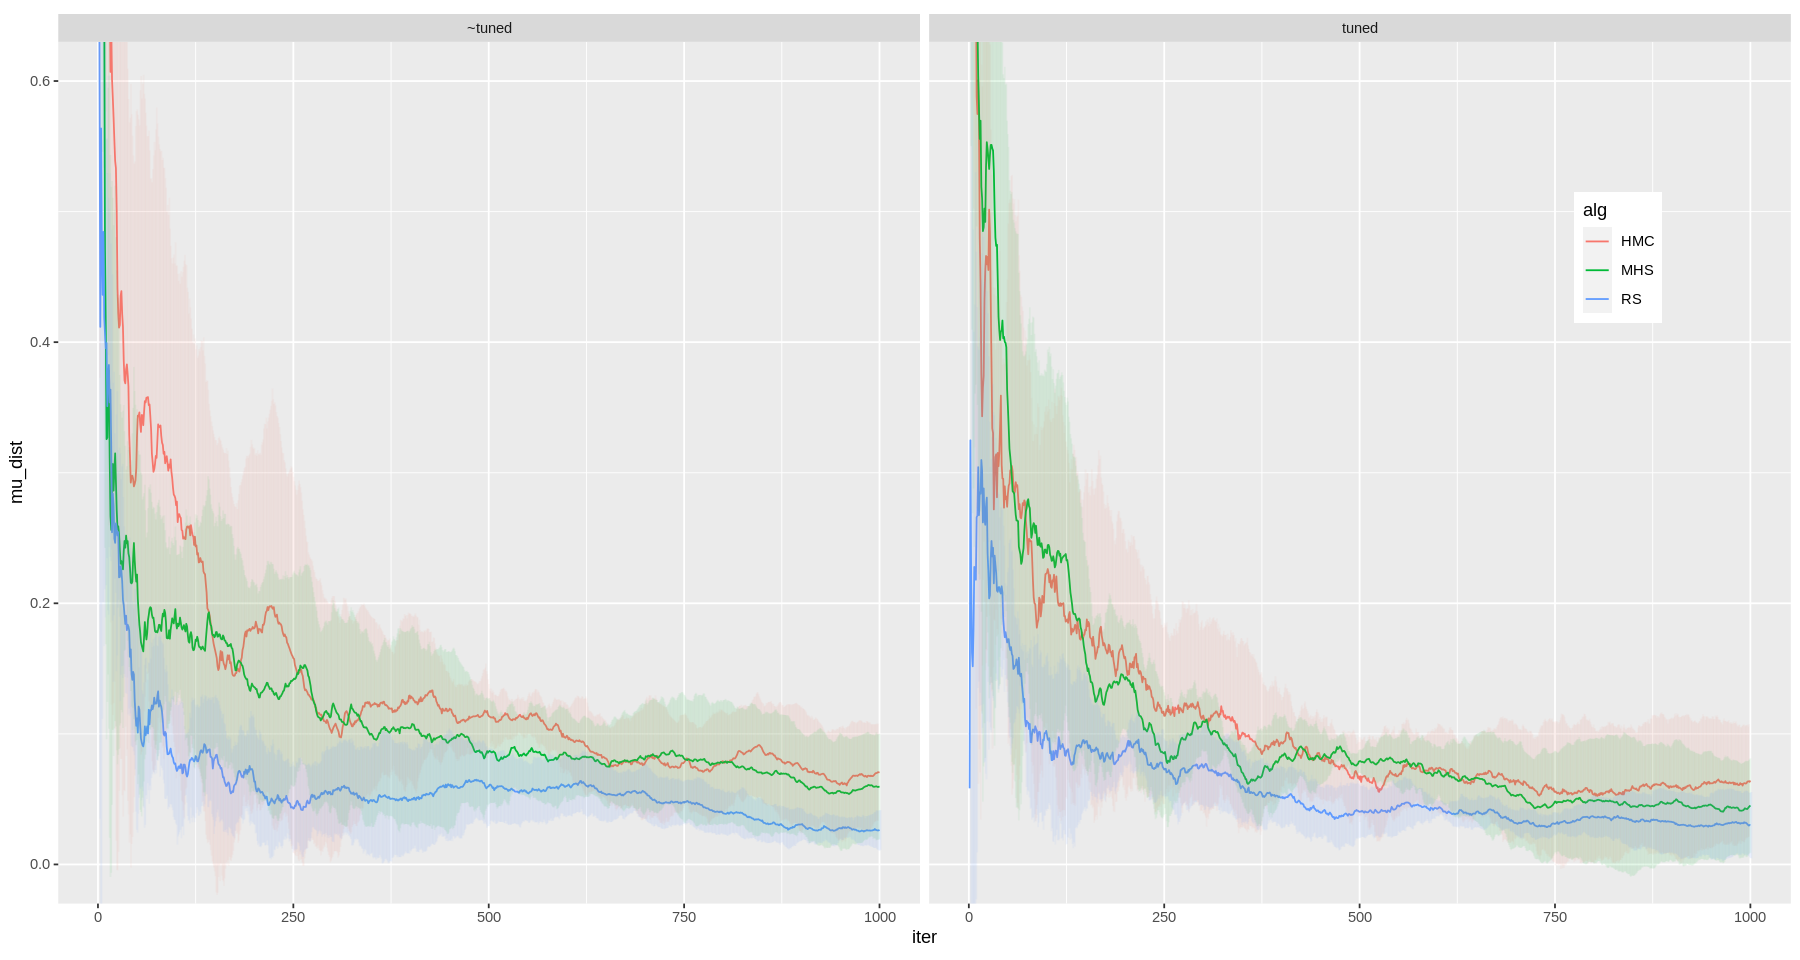

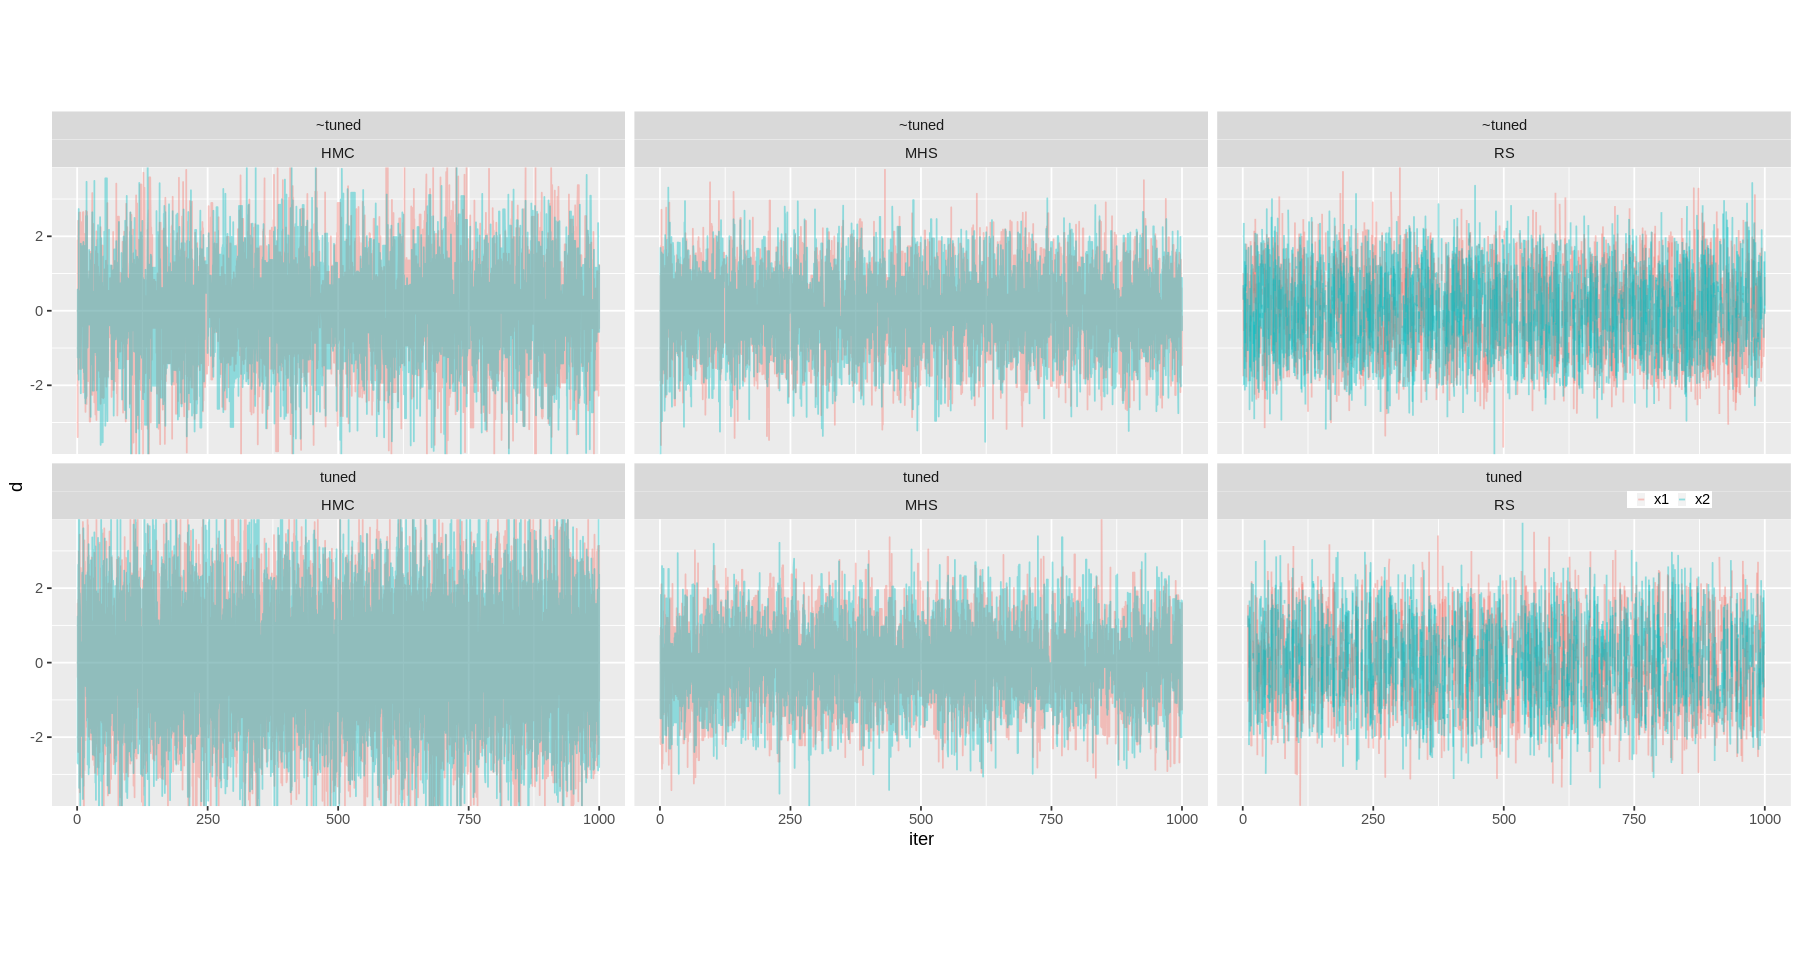

[1] "ESS"
  alg  tune        x1        x2         x1          x2
5 MHS  TRUE  412.9307  383.7177  15.126301   61.467287
2 MHS FALSE  370.5837  445.7980  47.324819   95.604722
1 HMC FALSE  600.8169  425.1626 172.999319  114.701697
6  RS  TRUE  518.0000  518.0000   8.455767    8.455767
3  RS FALSE  622.8000  622.8000   6.870226    6.870226
4 HMC  TRUE 1554.7983 1835.8123 904.735151 1507.537368
[1] "ESS/second"
  alg  tune       x1        x2         x1         x2
5 MHS  TRUE 229.4212  212.8794   9.573891  31.877661
2 MHS FALSE 205.6394  248.0030  24.125903  55.353031
1 HMC FALSE 333.0476  235.9370  93.862796  62.563038
6  RS  TRUE 287.7670  287.7670   5.813738   5.813738
3  RS FALSE 345.9865  345.9865   5.572865   5.572865
4 HMC  TRUE 864.0910 1019.0318 505.806959 831.800975


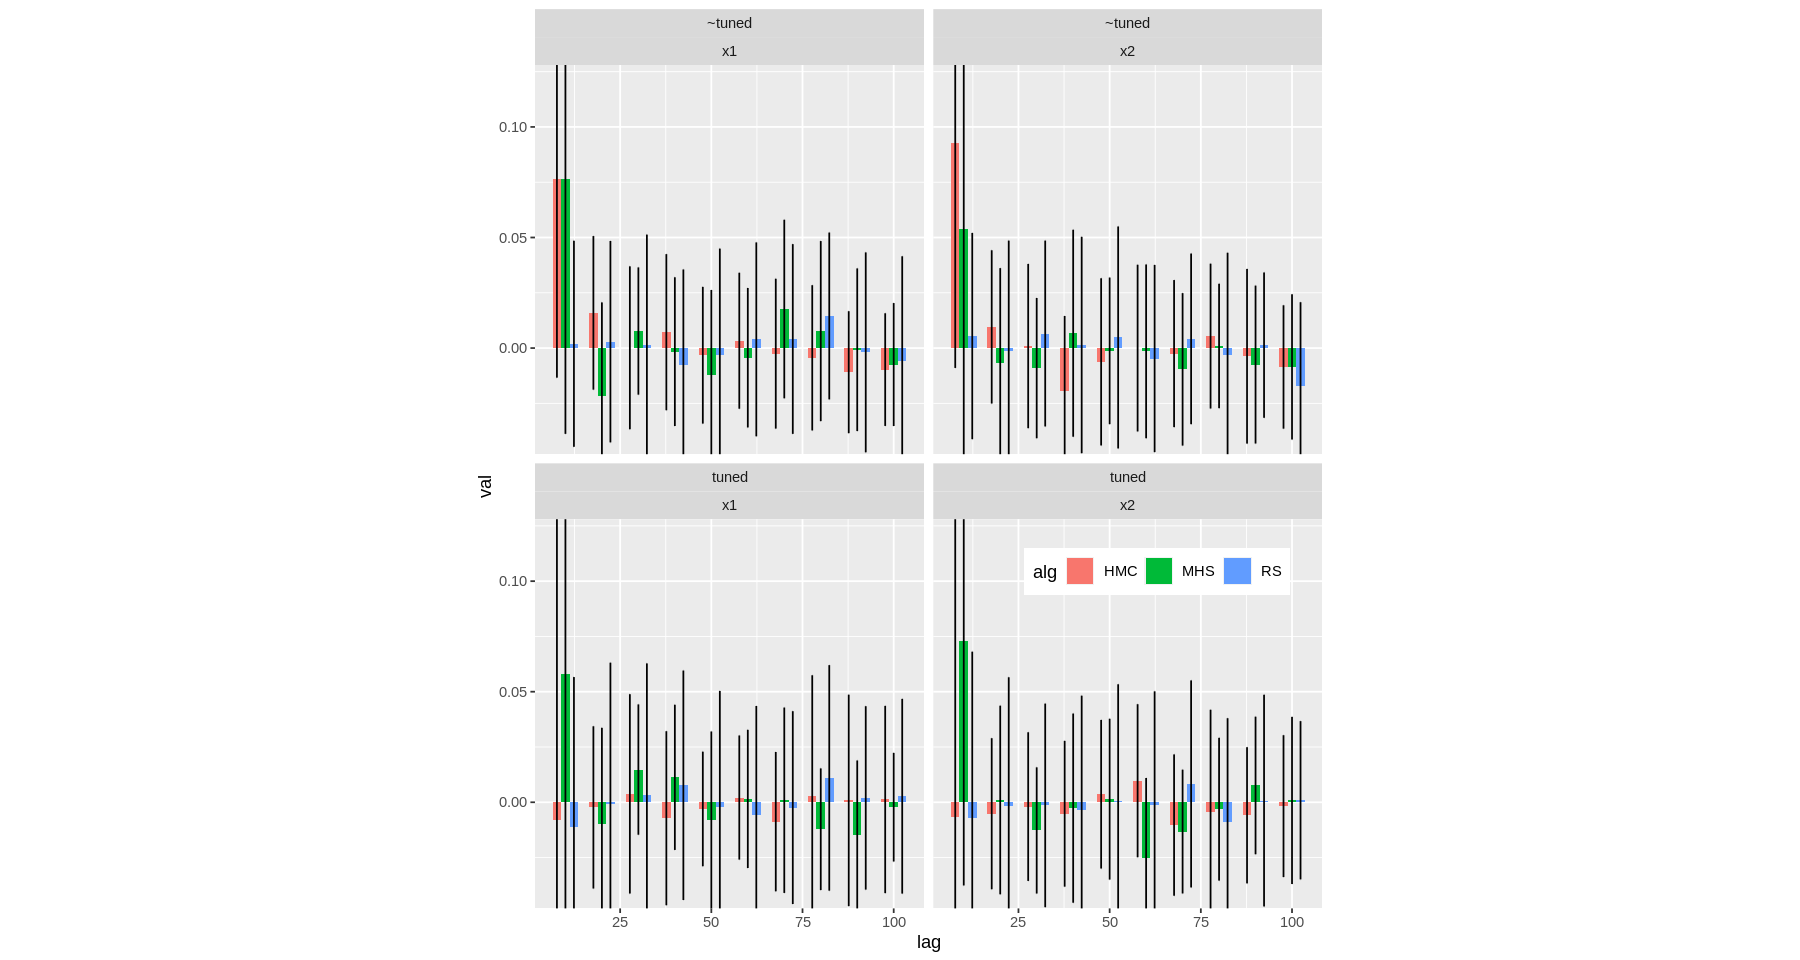

In [25]:
present_results(df.bivar, "bivar", keypoints=c(0,0), bnds=list("cvg"=c(0, 0.6), "acf"=c(-0.04, 0.12), "tra"=c(-3.5, 3.5)))

### 2.2. Banana function 

In [76]:
first_nan <- NULL

covmat <- diag(2)
# covmat <- matrix(c(5, -1, -1, 5), nrow=2)
B <- 0.05
banana.prob = function(x){
    return(exp(-(x[1]^2)/200 - 0.5 * (x[2] + B * x[1]^2 - 100 * B)^2))
}

banana.prob.log = function(x){
    return(-(x[1]^2)/200- 0.5 * (x[2]+ B * x[1]^2 - 100*B)^2)
}

banana.log.grad = function(x){
    g1 <- -(x[1])/100- 1.0 * (2* B * x[1]) * (x[2]+ B * x[1]^2 - 100*B)
    g2 <- - 1.0 * (x[2]+ B * x[1]^2 - 100*B)
    return(c(g1,g2))
}

#### 2.2.0 Hyperparameter search

In [81]:
# Grid for RS
rs.nburn <- c(0, 1, 3, 5)
rs.const <- c(1, exp(-10), exp(-100), exp(-500), exp(-800))
rs.covmat <- list(diag(2)) 

rs.params <- expand.grid(nburn=rs.nburn, const=rs.const, sigma=rs.covmat)
rs.params[, "mse"] <- NA

# Grid for MHS
mhs.nburn <- c(0, 1, 3, 5)
mhs.covmat <- list(diag(2)) 

mhs.params <- expand.grid(nburn=mhs.nburn, sigma=mhs.covmat)
mhs.params[, "mse"] <- NA

# Grid for HMC
hmc.nburn <- c(0, 1, 3, 5)
hmc.epsilon <- c(0.01, 0.1, 0.3, 1)
hmc.nleaps <- c(10, 30, 50)
hmc.covmat <- list(diag(2)) 

hmc.params <- expand.grid(nburn=hmc.nburn, sigma=hmc.covmat, nleaps=hmc.nleaps, epsilon=hmc.epsilon)
hmc.params[, "mse"] <- NA

# MSE for different hyperparameters
if(nrow(rs.params) > 100) {
    niter = 100
}else {niter = nrow(rs.params)}

for(i in 1:niter) {
    if (is.na(rs.params[i,"mse"])){
        if(niter < nrow(rs.params)){ 
            ind <- round(runif(1, min = 1, max = nrow(rs.params)))
        }else {ind <- i} 
        row <- rs.params[ind,]
        banana.params <- list(list("sampler"= RS,
                        "niter"=1000,
                        "burnin"=TRUE,
                        "nburn"=row$nburn,
                        "sigma"=row$sigma,
                        "epsilon"=0,
                        "nleaps"=0,
                        "const"=row$const))
        if (!file.exists(paste0("table/df- banana-grid-rs- ", i ," .csv"))){
        df.banana.grid <- generate_results(name = paste("banana-grid-rs-", ind), f = banana.prob,
                                        f.log = banana.prob.log, f.log.grad = banana.log.grad,
                                        f.samplers = banana.params)
        }else{
            df.banana.grid <- read.csv(paste0("table/df- banana-grid-rs- ", i ," .csv"))
        }
        df.banana.means <- df.banana.grid %>% group_by(run) %>% summarise_at(vars(x1, x2), funs(mean(., na.rm=TRUE)))
        rs.params[ind,"mse"] <- sqrt(sum(colMeans(df.banana.means[, c("x1", "x2")])^2))
    }
}
rs.params$sigma <- as.character(rs.params$sigma)
write.csv(rs.params, "banana-rs-params.csv")

# MSE for different hyperparameters
if(nrow(mhs.params) > 100) {
    niter = 100
}else {niter = nrow(mhs.params)}

for(i in 1:niter) {
    if (is.na(mhs.params[i,"mse"])){
        if(niter < nrow(mhs.params)){
            ind <- round(runif(1, min = 1, max = nrow(mhs.params)))
        }else {ind <- i} 
        row <- mhs.params[ind,]
        banana.params <- list(list("sampler"=MHS,
                        "niter"=1000,
                        "burnin"=TRUE,
                        "nburn"=row$nburn,
                        "sigma"=row$sigma,
                        "epsilon"=0,
                        "nleaps"=0,
                        "const"=0))
        if (!file.exists(paste0("table/df- banana-grid-mhs- ", i ," .csv"))){
        df.banana.grid <- generate_results(name = paste("banana-grid-mhs-", ind), f = banana.prob,
                                        f.log = banana.prob.log, f.log.grad = banana.log.grad,
                                        f.samplers = banana.params)
        }else{
            df.banana.grid <- read.csv(paste0("table/df- banana-grid-mhs- ", i ," .csv"))
        }
        df.banana.means <- df.banana.grid %>% group_by(run) %>% summarise_at(vars(x1, x2), funs(mean(., na.rm=TRUE)))
        mhs.params[ind,"mse"] <- sqrt(sum(colMeans(df.banana.means[, c("x1", "x2")])^2))
    }
}
mhs.params$sigma <- as.character(mhs.params$sigma)
write.csv(mhs.params, "banana-mhs-params.csv")

# MSE for different hyperparameters
if(nrow(hmc.params) > 100) {
    niter = 100
}else {niter = nrow(hmc.params)}

for(i in 1:niter) {
    if (is.na(hmc.params[i,"mse"])){
        if(niter < nrow(hmc.params)){
            ind <- round(runif(1, min = 1, max = nrow(hmc.params)))
        }else {ind <- i} 
        row <- hmc.params[ind,]
        banana.params <- list(list("sampler"=HMC,
                        "niter"=1000,
                        "burnin"=TRUE,
                        "nburn"=row$nburn,
                        "sigma"=row$sigma,
                        "epsilon"=row$epsilon,
                        "nleaps"=row$nleaps,
                        "const"=0))
        
        tryCatch(
            expr = {
                if (!file.exists(paste0("table/df- banana-grid-hmc- ", i ," .csv"))){
                    df.banana.grid <- generate_results(name = paste("banana-grid-hmc-", ind), f = banana.prob,
                                                f.log = banana.prob.log, f.log.grad = banana.log.grad,
                                                f.samplers = banana.params)
                }else{
                    df.banana.grid <- read.csv(paste0("table/df- banana-grid-hmc- ", i ," .csv"))
                }
                df.banana.means <- df.banana.grid %>% group_by(run) %>% summarise_at(vars(x1, x2), funs(mean(., na.rm=TRUE)))
                hmc.params[ind,"mse"] <- sqrt(sum(colMeans(df.banana.means[, c("x1", "x2")])^2))
            },
            error = function(e){ 
                print(paste0("Error: ", banana.params))
            }
        )
    }
}
hmc.params$sigma <- as.character(hmc.params$sigma)
write.csv(hmc.params, "banana-hmc-params.csv")

# find min parameters: run for those parameters
hmc.params <- hmc.params[order(hmc.params$mse), ]
mhs.params <- mhs.params[order(mhs.params$mse), ]
rs.params <- rs.params[order(rs.params$mse), ]

hmc.min.param <- hmc.params[1, ]
mhs.min.param <- mhs.params[1, ]
rs.min.param <- rs.params[1, ]

print("RS-hyperparams")
print(rs.min.param)
print(paste("mean diff: ", mean(rs.params$mse, na.rm = TRUE) - rs.min.param$mse))
print(paste("std: ", sqrt(var(rs.params$mse, na.rm = TRUE))))

print("MHS-hyperparams")
print(mhs.min.param)
print(paste("mean diff: ", mean(mhs.params$mse, na.rm = TRUE) - mhs.min.param$mse))
print(paste("std: ", sqrt(var(mhs.params$mse, na.rm = TRUE))))

print("HMC-hyperparams")
print(hmc.min.param)
print(paste("mean diff: ", mean(hmc.params$mse, na.rm = TRUE) - hmc.min.param$mse))
print(paste("std: ", sqrt(var(hmc.params$mse, na.rm = TRUE))))

[1] "RS-hyperparams"
   nburn         const         sigma        mse
14     1 7.124576e-218 c(1, 0, 0, 1) 0.02855709
[1] "mean diff:  0.632196525878152"
[1] "std:  0.642767400434169"
[1] "MHS-hyperparams"
  nburn         sigma      mse
3     3 c(1, 0, 0, 1) 1.235221
[1] "mean diff:  1.15969195850258"
[1] "std:  1.22242461596225"
[1] "HMC-hyperparams"
   nburn         sigma nleaps epsilon      mse
12     5 c(1, 0, 0, 1)     50    0.01 1.721407
[1] "mean diff:  2.877313202031"
[1] "std:  2.66937626464428"


#### 2.2.1 Comparison

In [18]:
# specify parameters
banana.params <- list(list("sampler"=RS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=FALSE,
                      "nburn"=0,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=1),
                     list("sampler"=RS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=TRUE,
                      "nburn"=rs.min.param$nburn,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=rs.min.param$const),
                     list("sampler"=MHS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=FALSE,
                      "nburn"=0,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=0),
                     list("sampler"=MHS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=TRUE,
                      "nburn"=mhs.min.param$nburn,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=0),
                      list("sampler"=HMC,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=FALSE,
                      "nburn"=3,
                      "epsilon"=0.3,
                      "nleaps"=50,
                      "const"=1),
                     list("sampler"=HMC,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=TRUE,
                      "nburn"=hmc.min.param$nburn,
                      "epsilon"=hmc.min.param$epsilon,
                      "nleaps"=hmc.min.param$nleaps,
                      "const"=0))

df.banana <- generate_results(name = "banana", f = banana.prob, f.log = banana.prob.log, f.log.grad = banana.log.grad, f.samplers = banana.params)

Warning message:
“Removed 4190 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



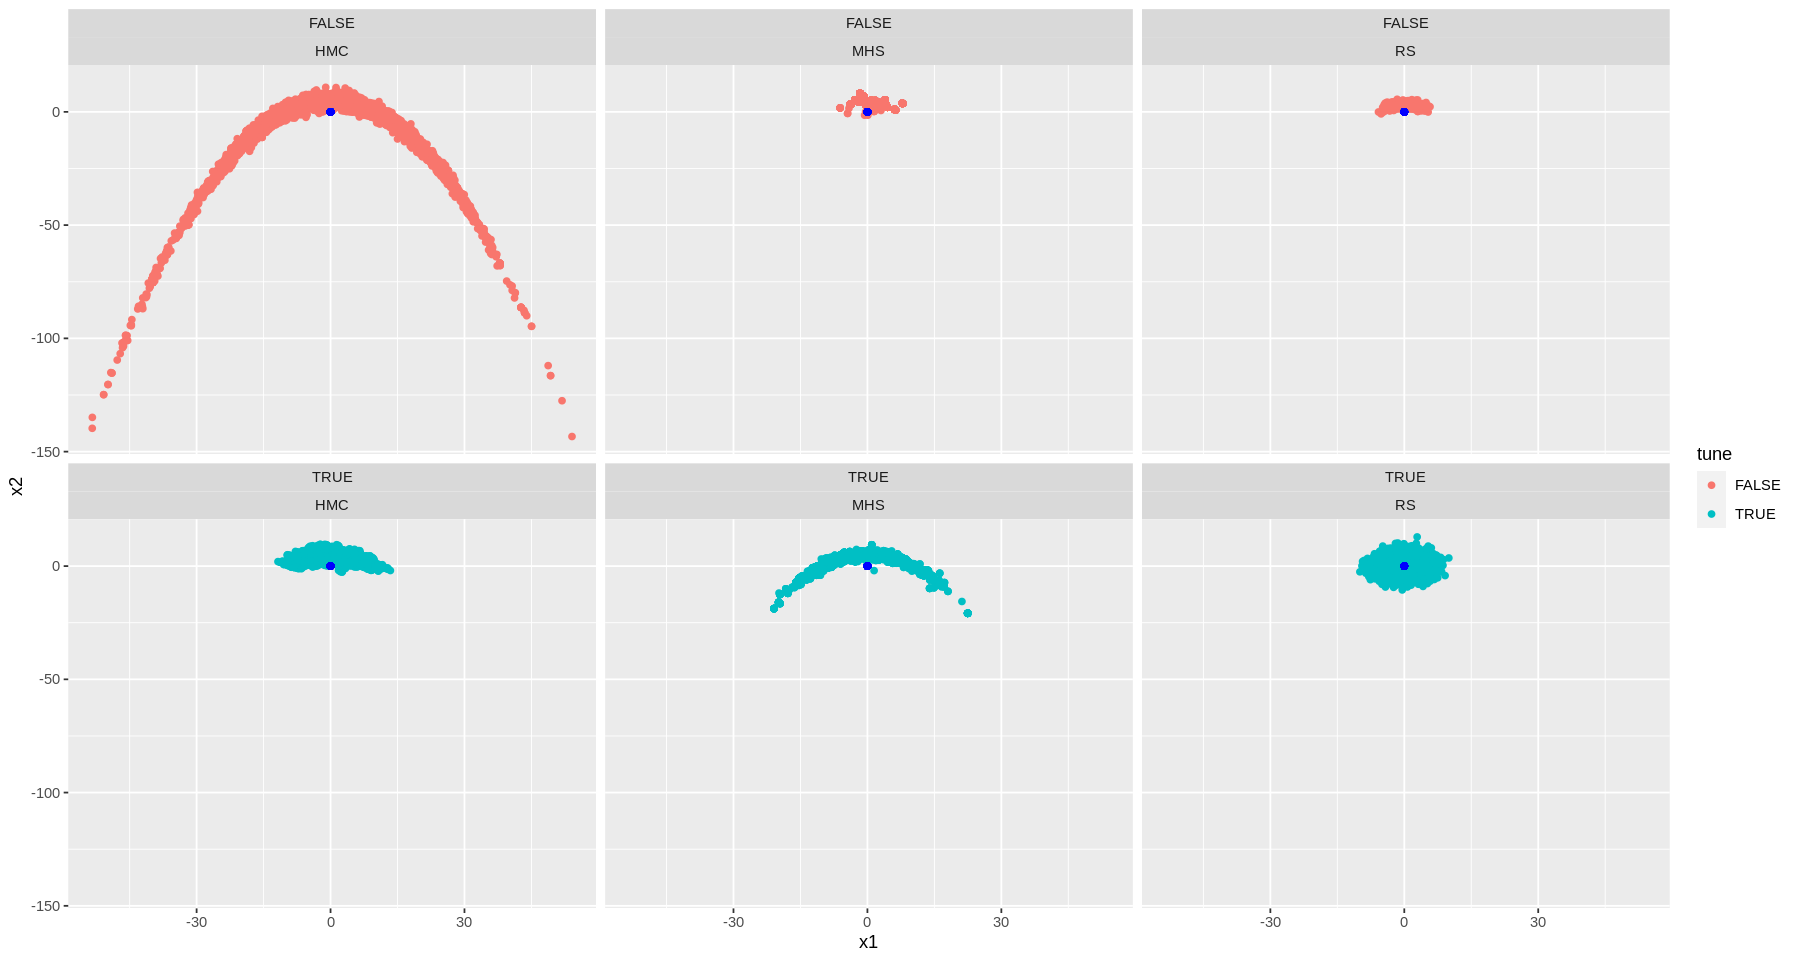

Saving 6.67 x 6.67 in image



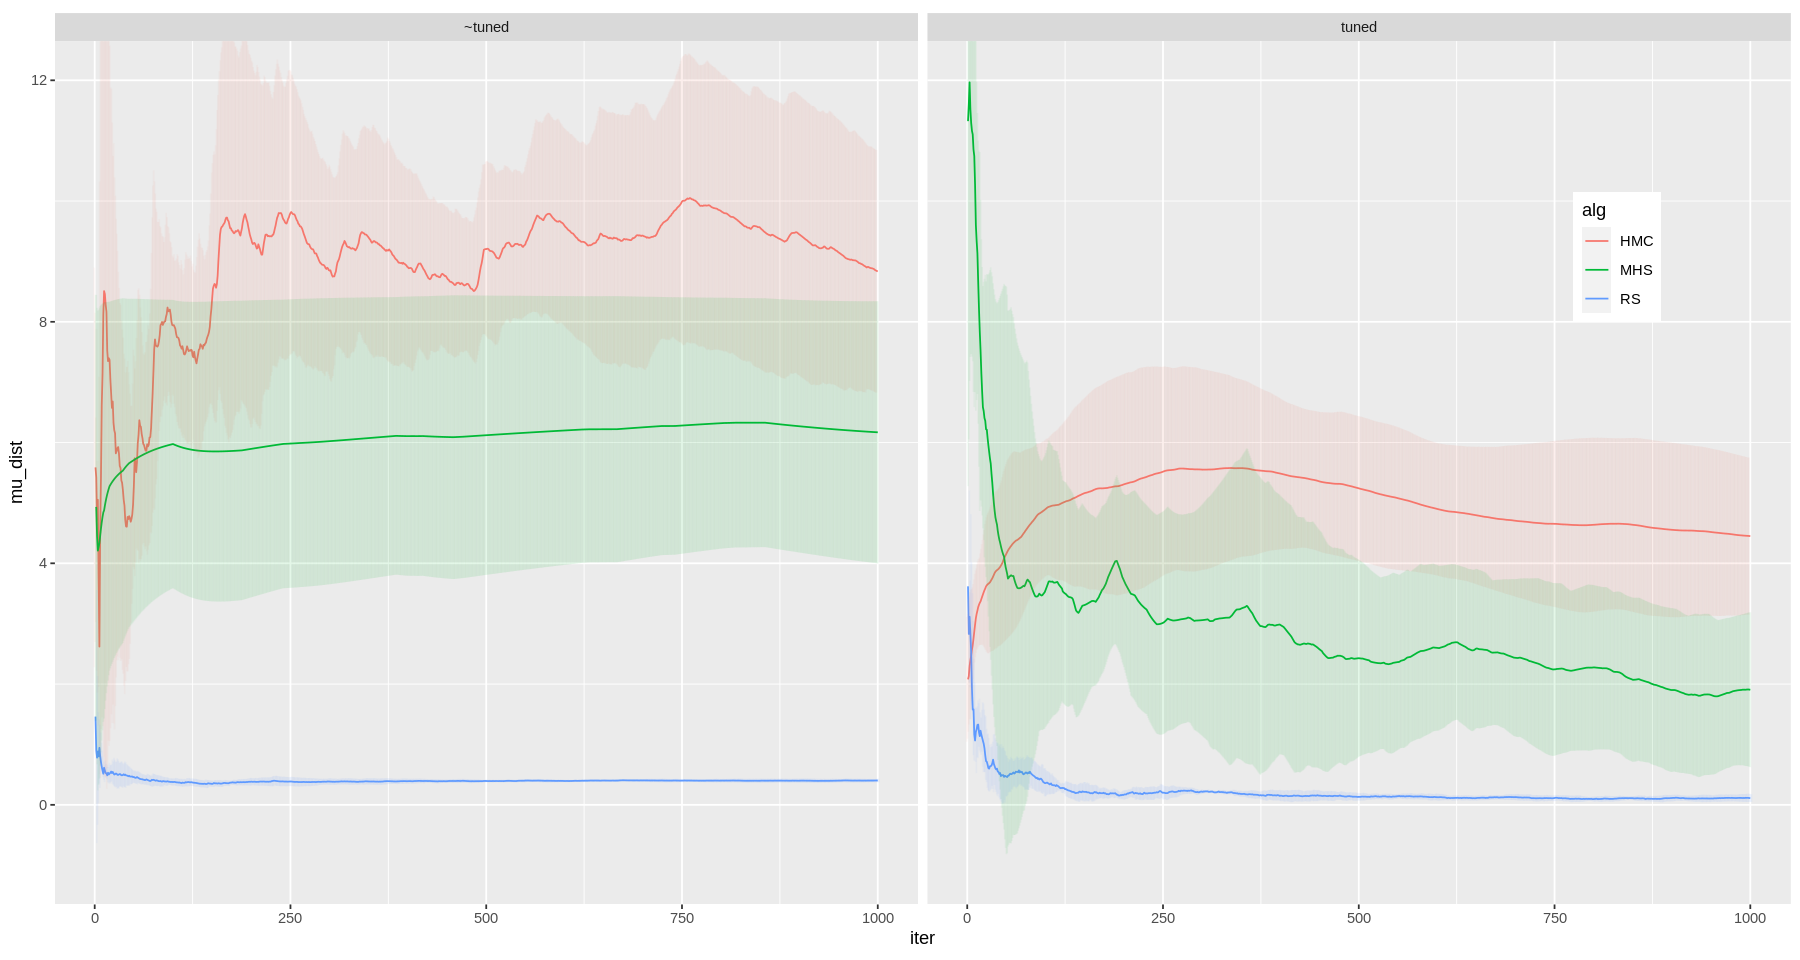

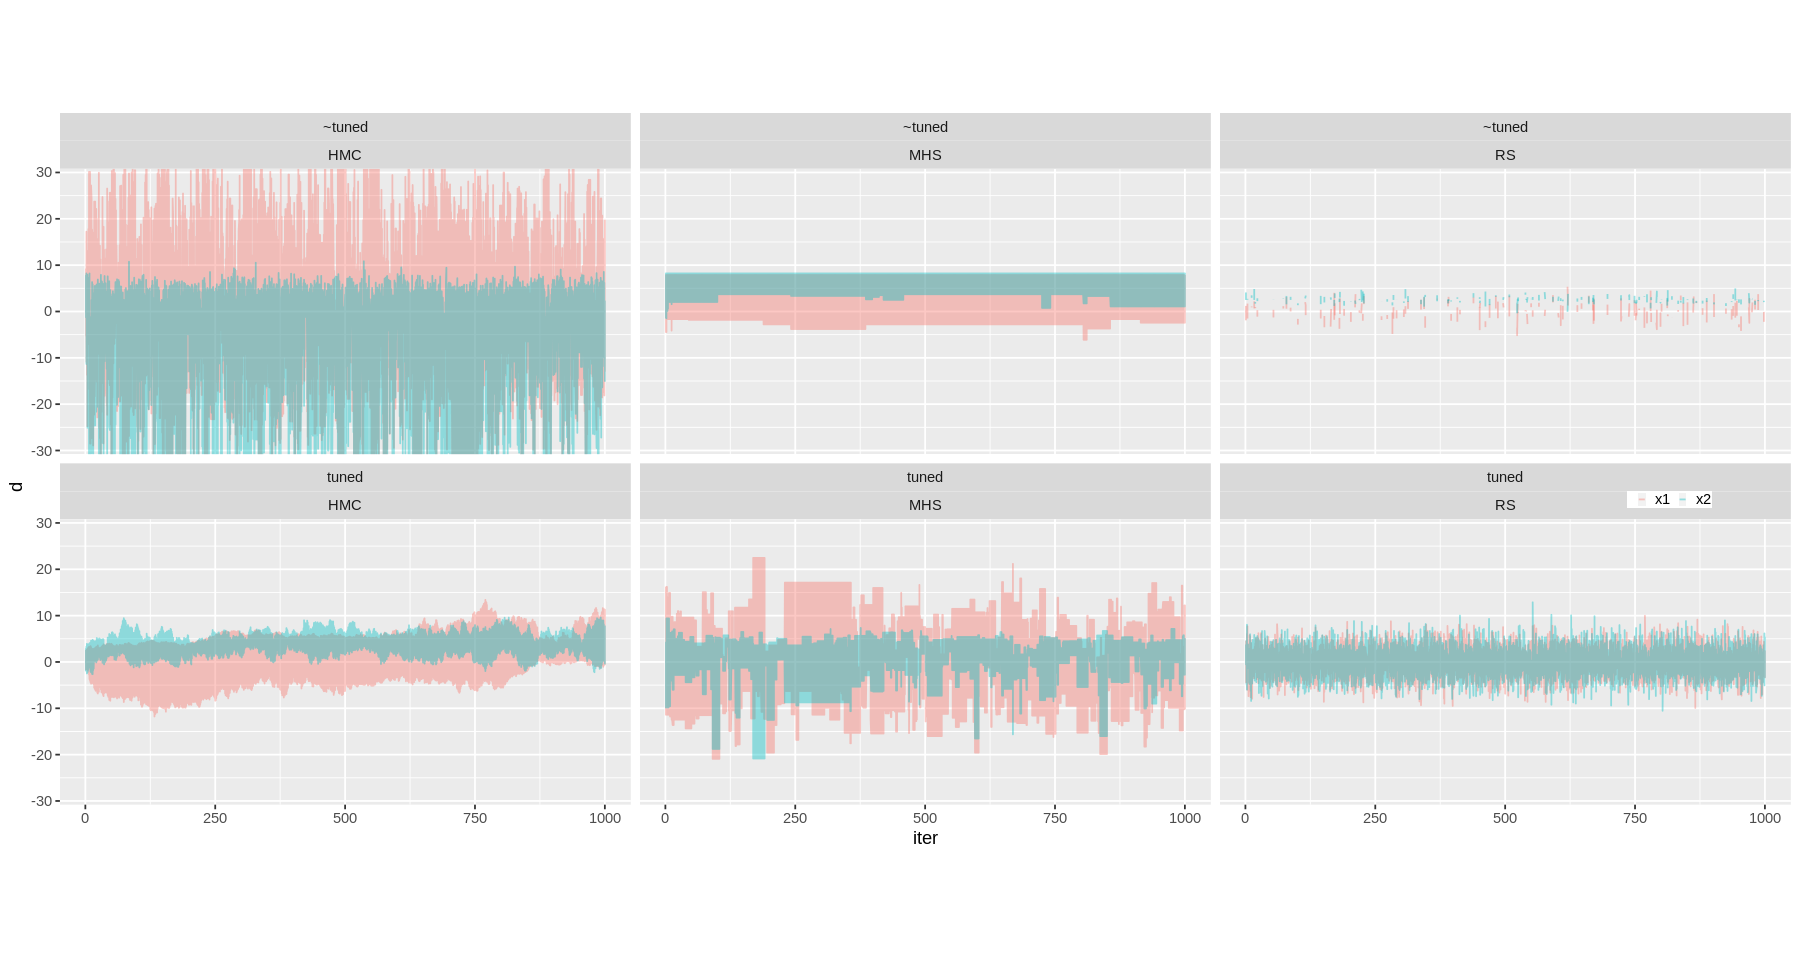

[1] "No variability observed in a component. Setting batch size to 1"
[1] "No variability observed in a component. Setting batch size to 1"
[1] "No variability observed in a component. Setting batch size to 1"
[1] "No variability observed in a component. Setting batch size to 1"
[1] "ESS"
  alg  tune          x1        x2        x1        x2
4 HMC  TRUE    7.033811  18.57816  1.050886 12.761214
5 MHS  TRUE   48.392442  46.72561 15.063928 16.013257
1 HMC FALSE  161.837197 116.67739 54.157838 56.886439
3  RS FALSE  182.903799 162.00000 53.560233 10.440307
6  RS  TRUE 1020.700768 995.63853 46.288325  9.752541
2 MHS FALSE         NaN       NaN        NA        NA
[1] "No variability observed in a component. Setting batch size to 1"
[1] "No variability observed in a component. Setting batch size to 1"
[1] "No variability observed in a component. Setting batch size to 1"
[1] "No variability observed in a component. Setting batch size to 1"
[1] "ESS/second"
  alg  tune         x1        x2   

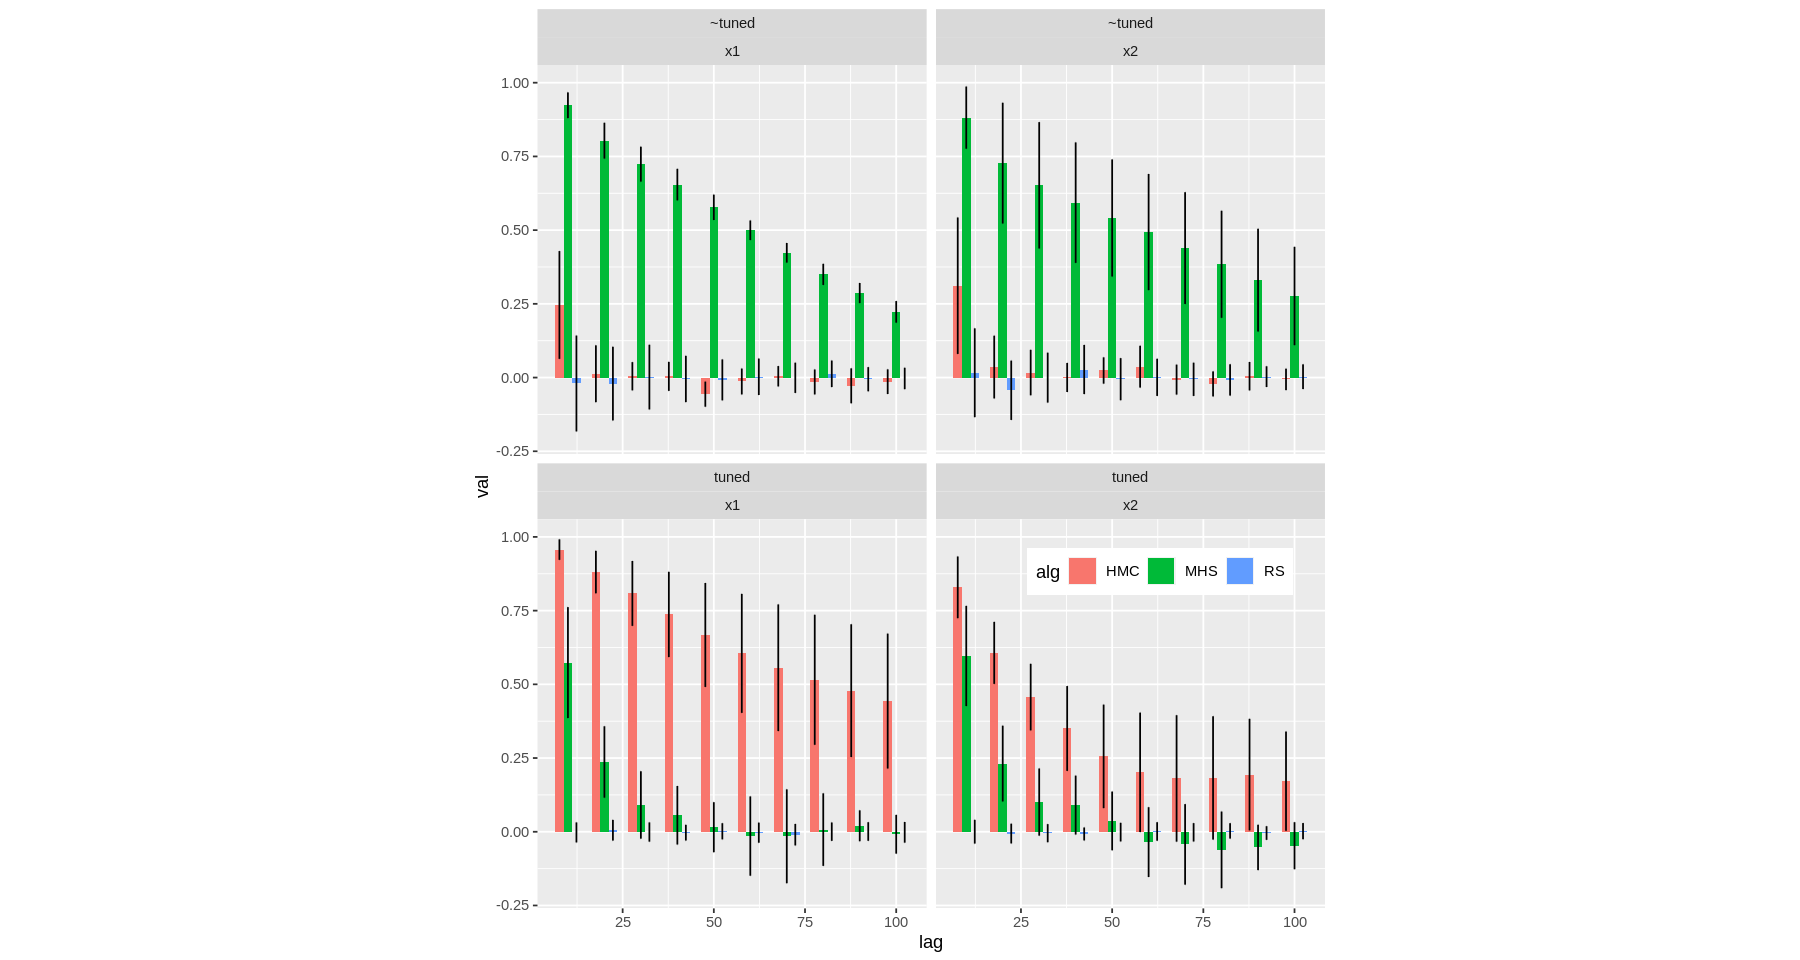

In [29]:
present_results(df.banana, "banana", keypoints=c(0,0), bnds=list("cvg"=c(-1, 12), "acf"=c(-0.2, 1), "tra"=c(-28, 28)))

### 2.3. Logistic regression likelihood (two columns)

In [30]:
dataset <- read.csv(file = '/home/bro/Documents/mat/HW3/datset.csv')
dist_center <- function(xcols){
    model <- glm(y ~.,family=binomial(link='logit'), data=dataset[,c(xcols, "y")])
    coef <- model$coefficients
    coef[["X1"]] <- c(coef[["(Intercept)"]])
    return(coef[2:length(coef)])
}

xcols <- c("X1", "X2")

X <- data.matrix(dataset[,xcols])
y <- data.matrix(dataset[,c("y")])

mu <- dist_center(xcols)

keypoints <- c(1.36245, -0.70776)

binom.prob = function(x){
    return(NULL) # not implemented
}

binom.prob.log = function(theta){
    if (is.null(dim(theta))) theta <- t(theta)
    if (all(dim(theta)==c(1,2))) theta <- t(theta) # for compatibility reasons HMC expect transpose of MHS
    z = X %*% theta
    return(-sum(log(1 + exp(-z)) + (1 - y) * z))
}

binom.log.grad = function(theta){
    z = exp(-(X %*% theta))
    tX <- t(X)
    tz <- z/(1+z)
    return(tX %*% tz - tX %*% (1 - y))
}

#### 2.3.0 Hyperparameter search

In [80]:
# Grid for RS
rs.nburn <- c(0, 1, 3, 5)
rs.const <- c(1, exp(-10), exp(-100), exp(-600), exp(-800))
rs.covmat <- list(diag(2)) 

rs.params <- expand.grid(nburn=rs.nburn, const=rs.const, sigma=rs.covmat)
rs.params[, "mse"] <- NA

# Grid for MHS
mhs.nburn <- c(0, 1, 3, 5)
mhs.covmat <- list(diag(2)) 

mhs.params <- expand.grid(nburn=mhs.nburn, sigma=mhs.covmat)
mhs.params[, "mse"] <- NA

# Grid for HMC
hmc.nburn <- c(1, 3, 5)
hmc.epsilon <- c(0.01, 0.1, 0.5)
hmc.nleaps <- c(50, 100)
hmc.covmat <- list(diag(2)) 

hmc.params <- expand.grid(nburn=hmc.nburn, sigma=hmc.covmat, nleaps=hmc.nleaps, epsilon=hmc.epsilon)
hmc.params[, "mse"] <- NA

# MSE for different hyperparameters
if(nrow(rs.params) > 100) {
    niter = 100
}else {niter = nrow(rs.params)}

for(i in 1:niter) {
    if (is.na(rs.params[i,"mse"])){
        if(niter < nrow(rs.params)){ 
            ind <- round(runif(1, min = 1, max = nrow(rs.params)))
        }else {ind <- i} 
        row <- rs.params[ind,]
        binom.params <- list(list("sampler"= RS,
                        "niter"=1000,
                        "burnin"=TRUE,
                        "nburn"=row$nburn,
                        "sigma"=row$sigma,
                        "epsilon"=0,
                        "nleaps"=0,
                        "const"=row$const))
        tryCatch(
            expr = {
                if (!file.exists(paste0("table/df- binom-grid-rs- ", i ," .csv"))){
                    df.binom.grid <- generate_results(name = paste("binom-grid-rs-", ind), f = binom.prob,
                                                f.log = binom.prob.log, f.log.grad = binom.log.grad,
                                                f.samplers = binom.params)
                }else{
                    df.binom.grid <- read.csv(paste0("table/df- binom-grid-rs- ", i ," .csv"))
                }
                df.binom.means <- df.binom.grid %>% group_by(run) %>% summarise_at(vars(x1, x2), funs(mean(., na.rm=TRUE)))
                rs.params[ind,"mse"] <- sqrt(sum(colMeans(df.binom.means[, c("x1", "x2")])^2))
            },
            error = function(e){ 
                print(paste0("(RS) Error: ", binom.params))
            }
        )
    }
}
rs.params$sigma <- as.character(rs.params$sigma)
write.csv(rs.params, "binom-rs-params.csv")

# MSE for different hyperparameters
if(nrow(mhs.params) > 100) {
    niter = 100
}else {niter = nrow(mhs.params)}

for(i in 1:niter) {
    if (is.na(mhs.params[i,"mse"])){
        if(niter < nrow(mhs.params)){
            ind <- round(runif(1, min = 1, max = nrow(mhs.params)))
        }else {ind <- i} 
        row <- mhs.params[ind,]
        binom.params <- list(list("sampler"=MHS,
                        "niter"=1000,
                        "burnin"=TRUE,
                        "nburn"=row$nburn,
                        "sigma"=row$sigma,
                        "epsilon"=0,
                        "nleaps"=0,
                        "const"=0))
        tryCatch(
            expr = {
                dataset <- read.csv(file = '/home/bro/Documents/mat/HW3/datset.csv')
                X <- data.matrix(dataset[,xcols])
                y <- data.matrix(dataset[,c("y")])
                
                if (!file.exists(paste0("table/df- binom-grid-mhs- ", i ," .csv"))){
                    df.binom.grid <- generate_results(name = paste("binom-grid-mhs-", ind), f = binom.prob,
                                                f.log = binom.prob.log, f.log.grad = binom.log.grad,
                                                f.samplers = binom.params)
                }else{
                    df.binom.grid <- read.csv(paste0("table/df- binom-grid-mhs- ", i ," .csv"))
                }
                df.binom.means <- df.binom.grid %>% group_by(run) %>% summarise_at(vars(x1, x2), funs(mean(., na.rm=TRUE)))
                mhs.params[ind,"mse"] <- sqrt(sum(colMeans(df.binom.means[, c("x1", "x2")])^2))
            },
            error = function(e){ 
                print(paste0("(MHS) Error: ", binom.params))
            }
        )
    }
}
mhs.params$sigma <- as.character(mhs.params$sigma)
write.csv(mhs.params, "binom-mhs-params.csv")

# MSE for different hyperparameters
if(nrow(hmc.params) > 100) {
    niter = 100
}else {niter = nrow(hmc.params)}

for(i in 1:niter) {
    if (is.na(hmc.params[i,"mse"])){
        if(niter < nrow(hmc.params)){
            ind <- round(runif(1, min = 1, max = nrow(hmc.params)))
        }else {ind <- i} 
        row <- hmc.params[ind,]
        binom.params <- list(list("sampler"=HMC,
                        "niter"=1000,
                        "burnin"=TRUE,
                        "nburn"=row$nburn,
                        "sigma"=row$sigma,
                        "epsilon"=row$epsilon,
                        "nleaps"=row$nleaps,
                        "const"=0))
        tryCatch(
            expr = {
                dataset <- read.csv(file = '/home/bro/Documents/mat/HW3/datset.csv')
                X <- data.matrix(dataset[,xcols])
                y <- data.matrix(dataset[,c("y")])
                
                if (!file.exists(paste0("table/df- binom-grid-hmc- ", i ," .csv"))){
                    df.binom.grid <- generate_results(name = paste("binom-grid-hmc-", ind), f = binom.prob,
                                                f.log = binom.prob.log, f.log.grad = binom.log.grad,
                                                f.samplers = binom.params)
                }else{
                    df.binom.grid <- read.csv(paste0("table/df- binom-grid-hmc- ", i ," .csv"))
                }
                df.binom.means <- df.binom.grid %>% group_by(run) %>% summarise_at(vars(x1, x2), funs(mean(., na.rm=TRUE)))
                hmc.params[ind,"mse"] <- sqrt(sum(colMeans(df.binom.means[, c("x1", "x2")])^2))
            },
            error = function(e){ 
                print(paste0(i, "(HMC) Error: ", binom.params))
            }
        )
    }
}
hmc.params$sigma <- as.character(hmc.params$sigma)
write.csv(hmc.params, "binom-hmc-params.csv")

# find min parameters: run for those parameters
hmc.params <- hmc.params[order(hmc.params$mse), ]
mhs.params <- mhs.params[order(mhs.params$mse), ]
rs.params <- rs.params[order(rs.params$mse), ]

hmc.min.param <- hmc.params[1, ]
mhs.min.param <- mhs.params[1, ]
rs.min.param <- rs.params[1, ]

print("RS-hyperparams")
print(rs.min.param)
print(paste("mean diff: ", mean(rs.params$mse, na.rm = TRUE) - rs.min.param$mse))
print(paste("std: ", sqrt(var(rs.params$mse, na.rm = TRUE))))

print("MHS-hyperparams")
print(mhs.min.param)
print(paste("mean diff: ", mean(mhs.params$mse, na.rm = TRUE) - mhs.min.param$mse))
print(paste("std: ", sqrt(var(mhs.params$mse, na.rm = TRUE))))

print("HMC-hyperparams")
print(hmc.min.param)
print(paste("mean diff: ", mean(hmc.params$mse, na.rm = TRUE) - hmc.min.param$mse))
print(paste("std: ", sqrt(var(hmc.params$mse, na.rm = TRUE))))

[1] "RS-hyperparams"
   nburn const         sigma        mse
18     1     0 c(1, 0, 0, 1) 0.06602954
[1] "mean diff:  0.637825455143222"
[1] "std:  0.528482382025747"
[1] "MHS-hyperparams"
  nburn         sigma      mse
3     3 c(1, 0, 0, 1) 1.477355
[1] "mean diff:  0.0532722568825572"
[1] "std:  0.0389892001948277"
[1] "HMC-hyperparams"
  nburn         sigma nleaps epsilon      mse
8     3 c(1, 0, 0, 1)     50     0.1 1.532619
[1] "mean diff:  0.0129141772442991"
[1] "std:  0.00765302932235874"


In [34]:
dataset <- read.csv(file = '/home/bro/Documents/mat/HW3/datset.csv')
X <- data.matrix(dataset[,xcols])
y <- data.matrix(dataset[,c("y")])

# specify parameters
binom.params <- list(
                    list("sampler"=RS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=FALSE,
                      "nburn"=0,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=exp(-600)),
                     list("sampler"=RS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=TRUE,
                      "nburn"=rs.min.param$nburn,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=rs.min.param$const),
                    list("sampler"=MHS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=FALSE,
                      "nburn"=0,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=0),
                     list("sampler"=MHS,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=TRUE,
                      "nburn"=mhs.min.param$nburn,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=0),
                      list("sampler"=HMC,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=FALSE,
                      "nburn"=0,
                      "epsilon"=0.1,
                      "nleaps"=10,
                      "const"=0),
                     list("sampler"=HMC,
                      "niter"=1000,
                      "sigma"=diag(2),
                      "burnin"=TRUE,
                      "nburn"=hmc.min.param$nburn,
                      "epsilon"=hmc.min.param$epsilon,
                      "nleaps"=hmc.min.param$nleaps,
                      "const"=0))

df.binom <- generate_results(name = "binom", f = binom.prob, f.log = binom.prob.log, f.log.grad = binom.log.grad, f.samplers = binom.params)

Warning message:
“Removed 4194 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



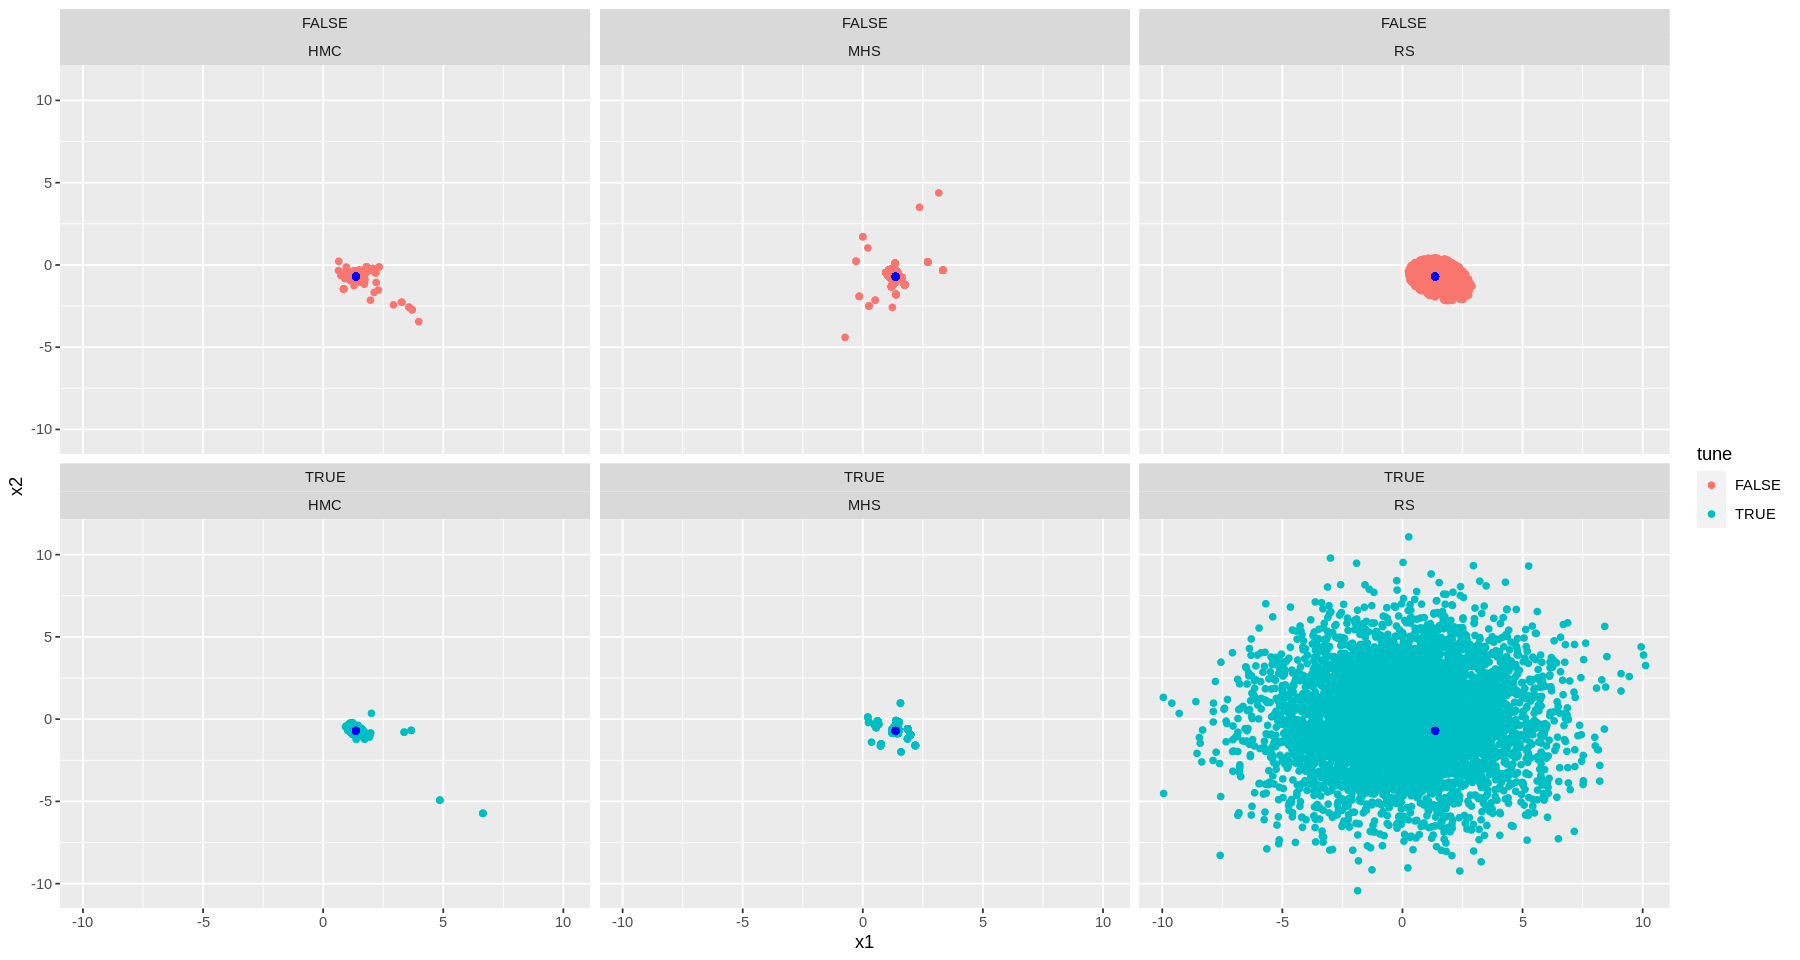

Saving 6.67 x 6.67 in image



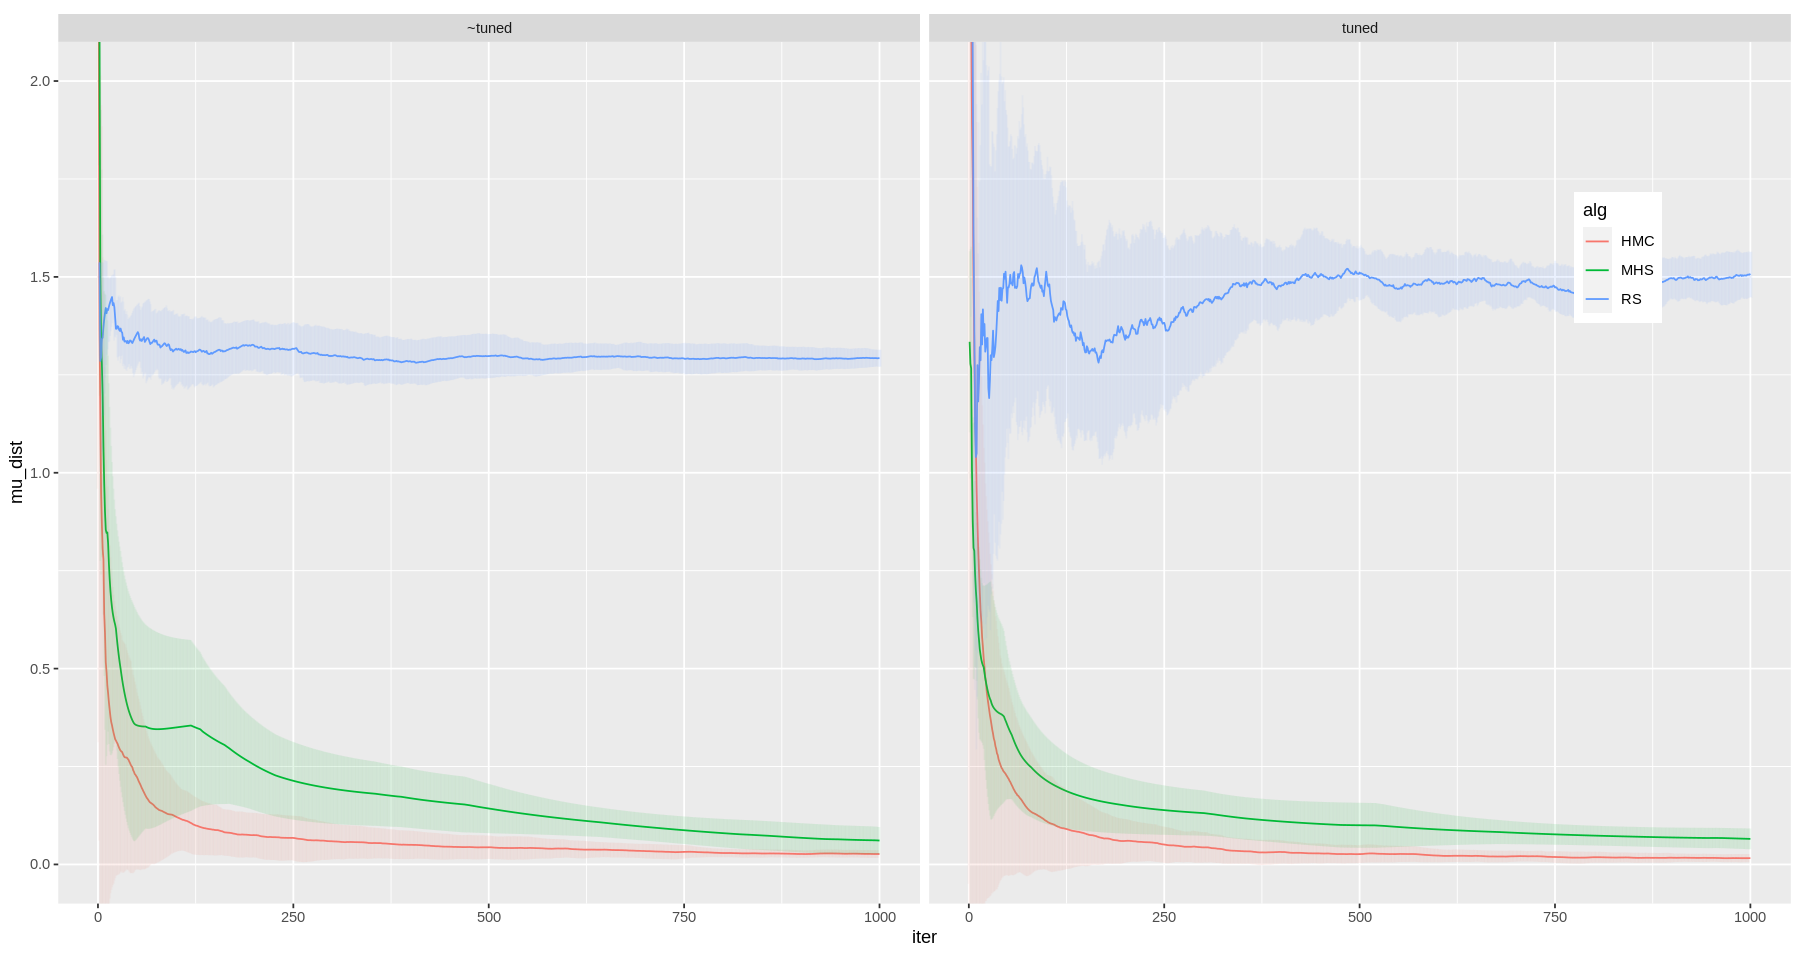

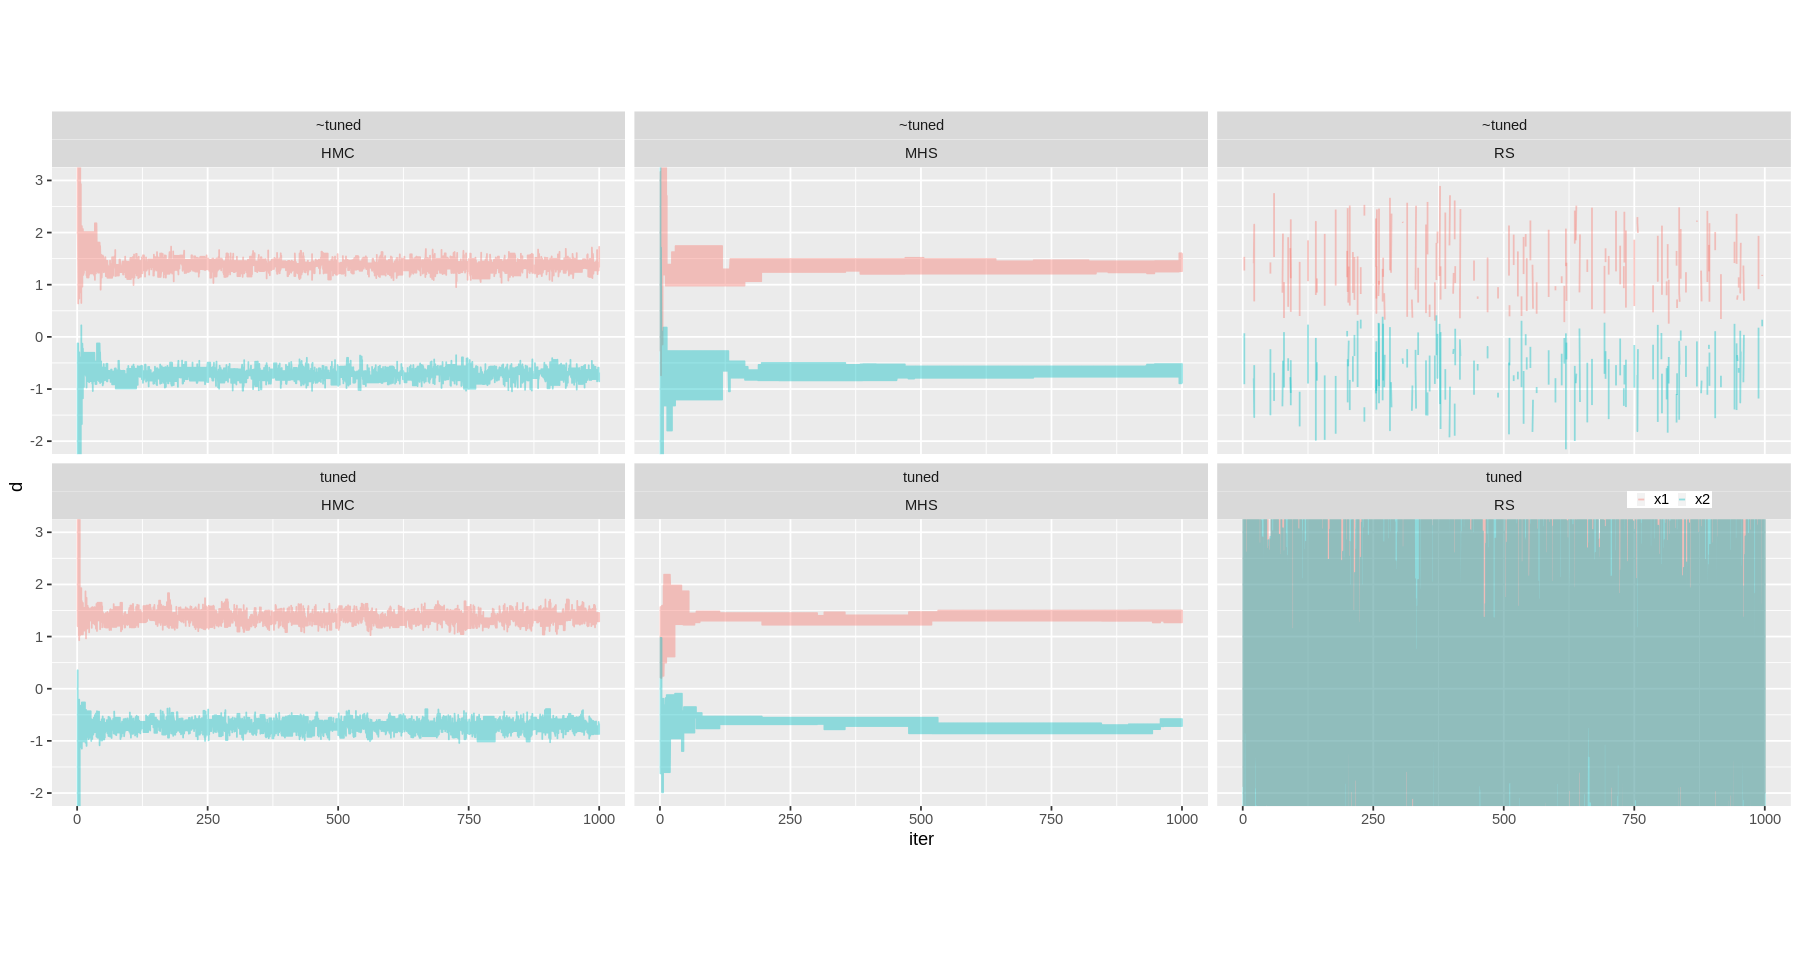

[1] "ESS"
  alg  tune         x1         x2        x1        x2
2 MHS FALSE   66.19871  173.22808  42.33063 300.53641
3  RS FALSE  161.20000  161.20000  14.82228  14.82228
4 HMC  TRUE  171.06491  175.26072  22.11997  67.90270
1 HMC FALSE  237.69915  221.58564 247.24089 194.81534
5 MHS  TRUE  413.01309   56.21301 831.20999  39.76801
6  RS  TRUE 1000.00000 1000.00000   0.00000   0.00000
[1] "ESS/second"
  alg  tune        x1        x2         x1        x2
2 MHS FALSE  18.47723  49.02646  12.116712 85.436998
3  RS FALSE  44.47758  44.47758   4.141845  4.141845
4 HMC  TRUE  47.06039  48.09476   4.411443 17.502797
1 HMC FALSE  66.28951  61.64243  70.715926 55.795997
5 MHS  TRUE 115.65285  15.60906 233.997326 11.135409
6  RS  TRUE 276.04111 276.04111   9.492849  9.492849


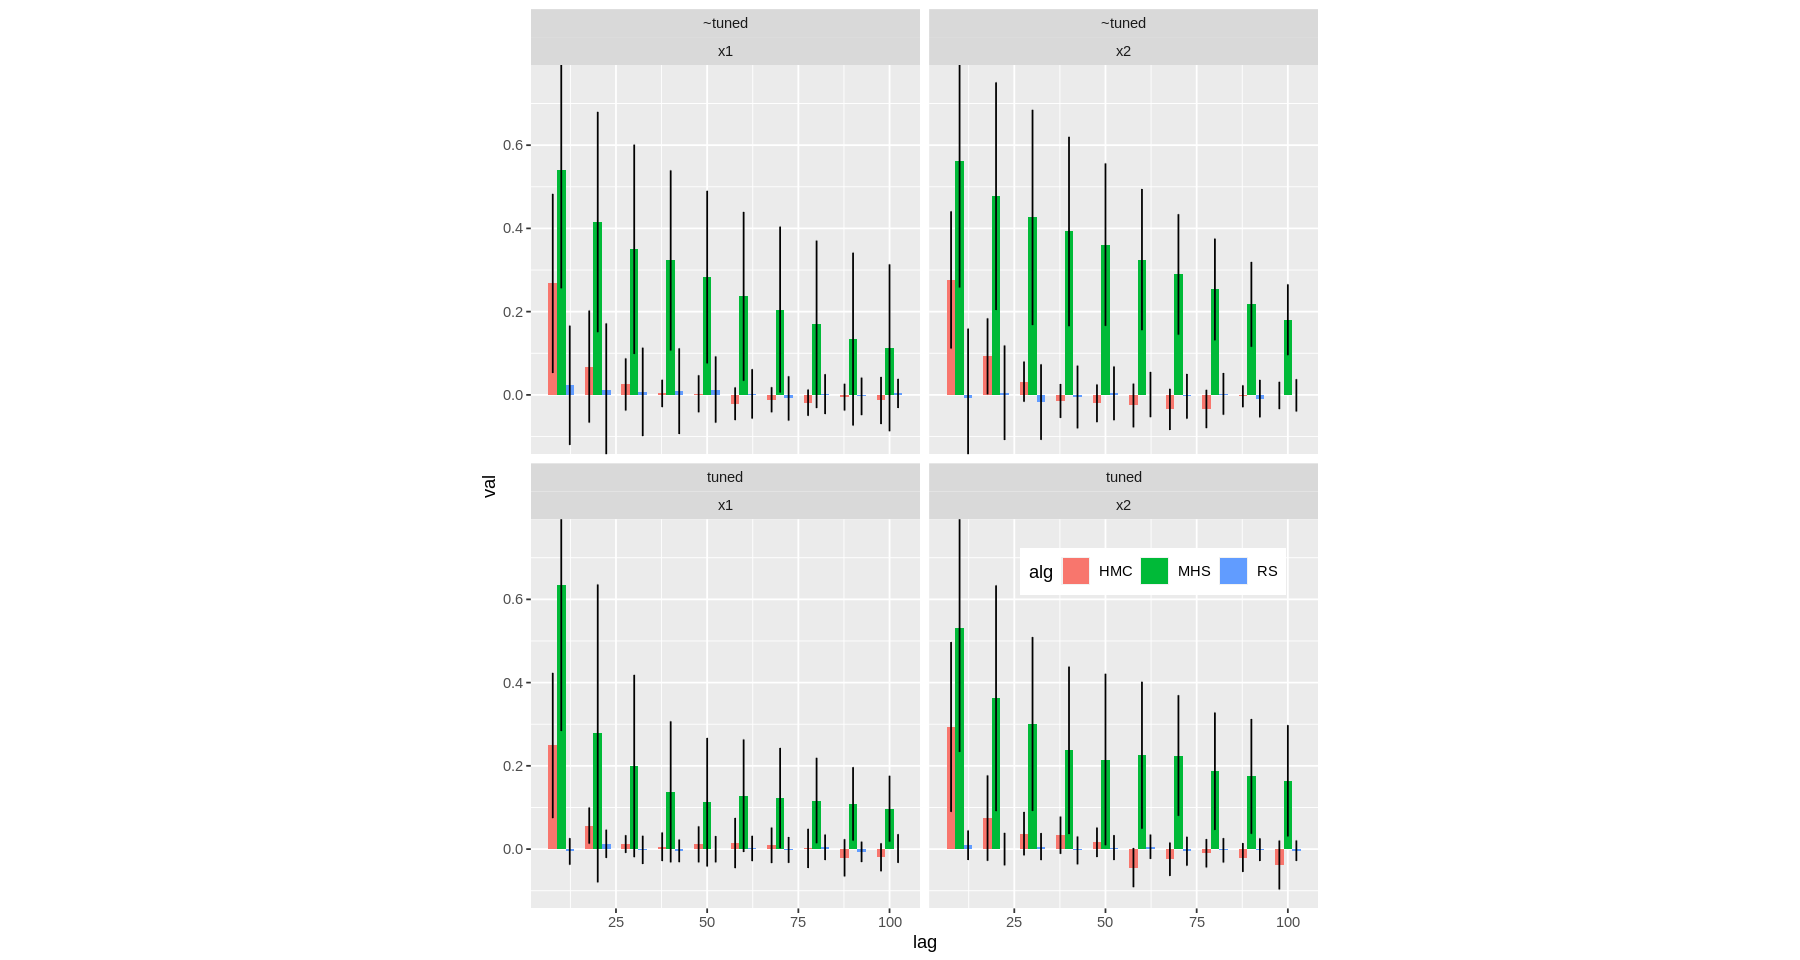

In [38]:
present_results(df.binom, "binom", keypoints = mu, bnds=list("cvg"=c(0, 2), "acf"=c(-0.1, 0.75), "tra"=c(-2, 3)))

[1] "MLE maximum: -514.656920103101"


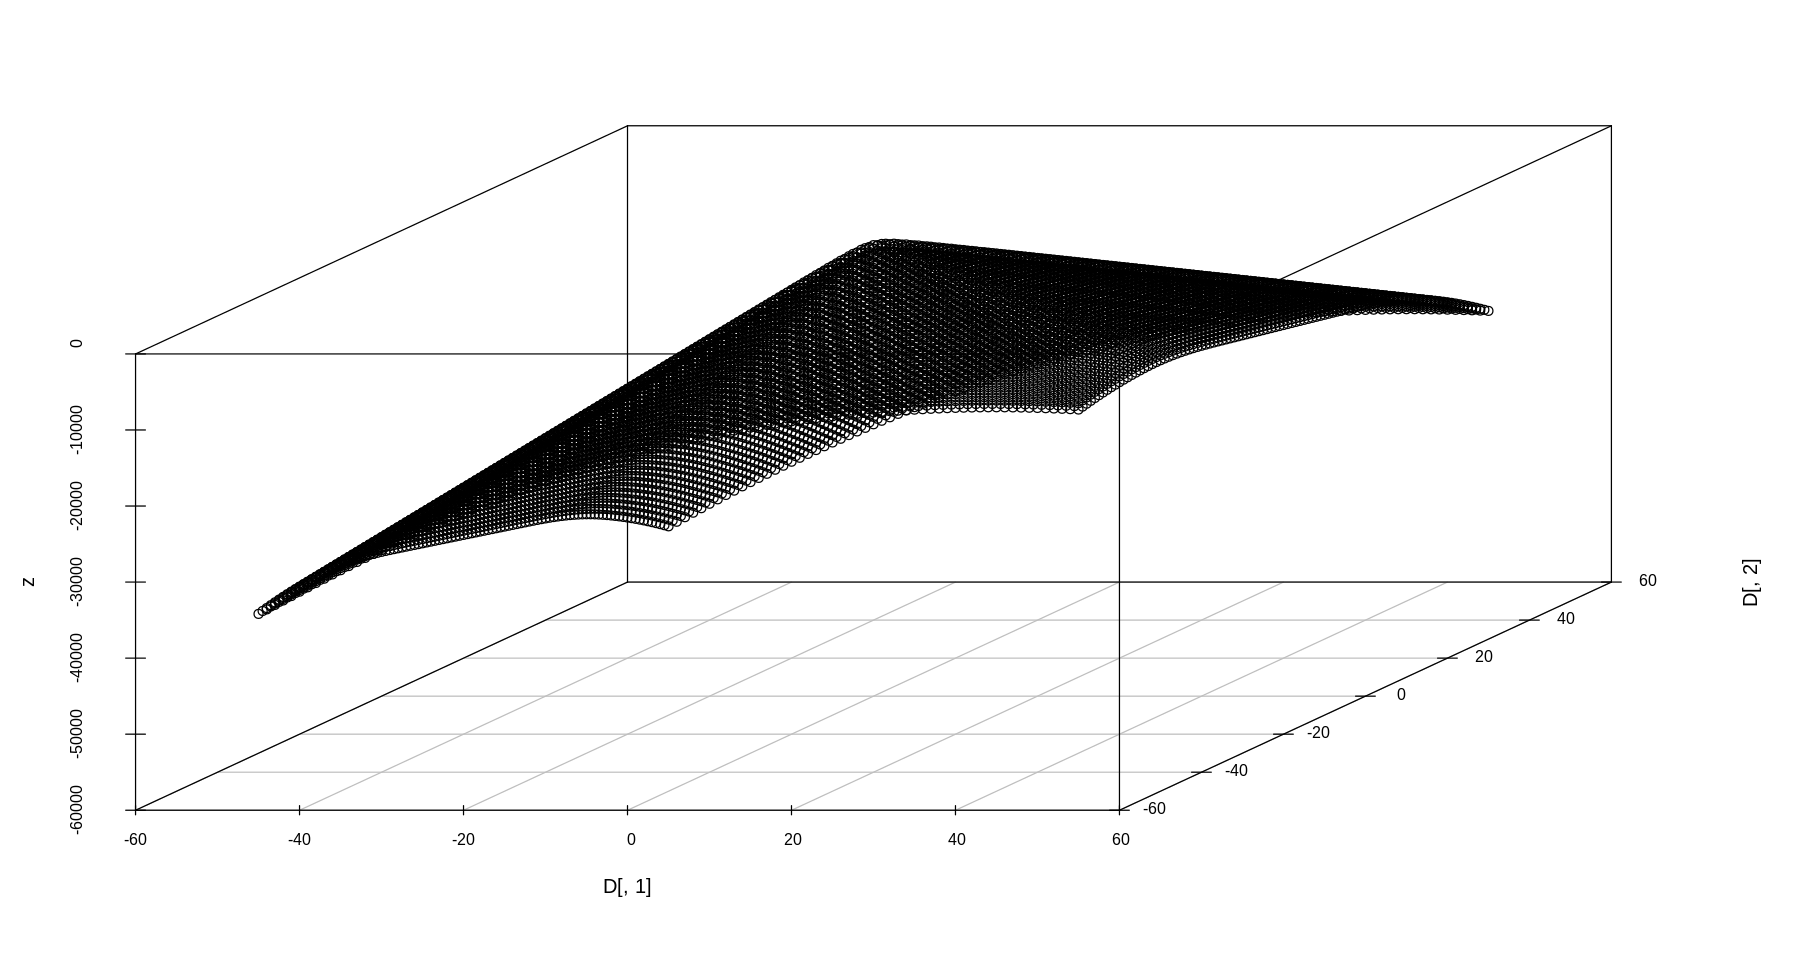

In [33]:
# plot function
X <- data.matrix(dataset[,c("X1", "X2")])
y <- data.matrix(dataset[,c("y")])

x <- seq(-50, 50, 1)
D <- expand.grid(x, x)
z <- matrix(apply(D, 1, binom.prob.log))

scatterplot3d(D[,1], D[,2], z, pch = 1, angle = 45)
print(paste0("MLE maximum: ", max(z)))

### 2.4. Logistic regression likelihood (all columns)

In [50]:
dataset <- read.csv(file = '/home/bro/Documents/mat/HW3/datset.csv')

xcols <- c("X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11")
xdim <- length(xcols)
X <- data.matrix(dataset[,xcols])
y <- data.matrix(dataset[,c("y")])

mu <- dist_center(xcols)

binom.prob = function(x){
    return(NULL) # not implemented
}

binom.prob.log = function(theta){
    if (is.null(dim(theta))) theta <- t(theta)
    if (dim(theta)[1]==1) theta <- t(theta) # for compatibility reasons HMC expect transpose of MHS
    z = X %*% theta
    return(-sum(log(1 + exp(-z)) + (1 - y) * z))
}

binom.log.grad = function(theta){
    z = exp(-(X %*% theta))
    tX <- t(X)
    tz <- z/(1+z)
    return(tX %*% tz - tX %*% (1 - y))
}

#### 2.4.0 Hyperparameter tuning

In [83]:
# Grid for MHS
mhs.nburn <- c(0, 1, 3, 5)
mhs.covmat <- list(diag(11)) 

mhs.params <- expand.grid(nburn=mhs.nburn, sigma=mhs.covmat)
mhs.params[, "mse"] <- NA

# Grid for HMC
hmc.nburn <- c(1, 3, 5)
hmc.epsilon <- c(0.01, 0.1, 0.5)
hmc.nleaps <- c(50, 100)
hmc.covmat <- list(diag(11)) 

hmc.params <- expand.grid(nburn=hmc.nburn, sigma=hmc.covmat, nleaps=hmc.nleaps, epsilon=hmc.epsilon)
hmc.params[, "mse"] <- NA

# MSE for different hyperparameters
if(nrow(mhs.params) > 100) {
    niter = 100
}else {niter = nrow(mhs.params)}

for(i in 1:niter) {
    if (is.na(mhs.params[i,"mse"])){
        if(niter < nrow(mhs.params)){
            ind <- round(runif(1, min = 1, max = nrow(mhs.params)))
        }else {ind <- i} 
        row <- mhs.params[ind,]
        binom.params <- list(list("sampler"=MHS,
                        "niter"=1000,
                        "burnin"=TRUE,
                        "nburn"=row$nburn,
                        "sigma"=row$sigma,
                        "epsilon"=0,
                        "nleaps"=0,
                        "const"=0))
        tryCatch(
            expr = {
                dataset <- read.csv(file = '/home/bro/Documents/mat/HW3/datset.csv')
                X <- data.matrix(dataset[,xcols])
                y <- data.matrix(dataset[,c("y")])
                if (!file.exists(paste0("table/df- binom-full-grid-mhs- ", i ," .csv"))){
                    df.binom.grid <- generate_results(name = paste("binom-full-grid-mhs-", ind), f = binom.prob,
                                                f.log = binom.prob.log, f.log.grad = binom.log.grad,
                                                f.samplers = binom.params, dim = 11)
                }else{
                    df.binom.grid <- read.csv(paste0("table/df- binom-full-grid-mhs- ", i ," .csv"))
                }
                df.binom.means <- df.binom.grid %>% group_by(run) %>% summarise_at(vars(x1, x2), funs(mean(., na.rm=TRUE)))
                mhs.params[ind,"mse"] <- sqrt(sum(colMeans(df.binom.means[, c("x1", "x2")])^2))
            },
            error = function(e){ 
                print(dim(X))
                print(paste0("(MHS) Error: ", binom.params))
            }
        )
    }
}
mhs.params$sigma <- as.character(mhs.params$sigma)
write.csv(mhs.params, "binom-full-mhs-params.csv")

# MSE for different hyperparameters
if(nrow(hmc.params) > 100) {
    niter = 100
}else {niter = nrow(hmc.params)}

for(i in 1:niter) {
    if (is.na(hmc.params[i,"mse"])){
        if(niter < nrow(hmc.params)){
            ind <- round(runif(1, min = 1, max = nrow(hmc.params)))
        }else {ind <- i} 
        row <- hmc.params[ind,]
        binom.params <- list(list("sampler"=HMC,
                        "niter"=1000,
                        "burnin"=TRUE,
                        "nburn"=row$nburn,
                        "sigma"=row$sigma,
                        "epsilon"=row$epsilon,
                        "nleaps"=row$nleaps,
                        "const"=0))
        tryCatch(
            expr = {
                dataset <- read.csv(file = '/home/bro/Documents/mat/HW3/datset.csv')
                X <- data.matrix(dataset[,xcols])
                y <- data.matrix(dataset[,c("y")])
                if (!file.exists(paste0("table/df- binom-full-grid-hmc- ", i ," .csv"))){
                    df.binom.grid <- generate_results(name = paste("binom-full-grid-hmc-", ind), f = binom.prob,
                                                    f.log = binom.prob.log, f.log.grad = binom.log.grad,
                                                    f.samplers = binom.params, dim = 11)
                }else{
                    df.binom.grid <- read.csv(paste0("table/df- binom-full-grid-hmc- ", i ," .csv"))
                }
                df.binom.means <- df.binom.grid %>% group_by(run) %>% summarise_at(vars(x1, x2), funs(mean(., na.rm=TRUE)))
                hmc.params[ind,"mse"] <- sqrt(sum(colMeans(df.binom.means[, c("x1", "x2")])^2))
            },
            error = function(e){
                print(e)
                # print(paste0("(HMC) Error: ", binom.params))
            }
        )
    }
}
hmc.params$sigma <- as.character(hmc.params$sigma)
write.csv(hmc.params, "binom-full-hmc-params.csv")

# find min parameters: run for those parameters
hmc.params <- hmc.params[order(hmc.params$mse), ]
mhs.params <- mhs.params[order(mhs.params$mse), ]

hmc.min.param <- hmc.params[1, ]
mhs.min.param <- mhs.params[1, ]

print("MHS-hyperparams")
print(mhs.min.param)
print(paste("mean diff: ", mean(mhs.params$mse, na.rm = TRUE) - mhs.min.param$mse))
print(paste("std: ", sqrt(var(mhs.params$mse, na.rm = TRUE))))

print("HMC-hyperparams")
print(hmc.min.param)
print(paste("mean diff: ", mean(hmc.params$mse, na.rm = TRUE) - hmc.min.param$mse))
print(paste("std: ", sqrt(var(hmc.params$mse, na.rm = TRUE))))

[1] "MHS-hyperparams"
  nburn
3     3
                                                                                                                                                                                                                                                                                                                                                                         sigma
3 c(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)
       mse
3 1.151908
[1] "mean diff:  0.178269808041363"
[1] "std:  0.141374425100128"
[1] "HMC-hyperparams"
  nburn
4     1
                                                                                                      

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



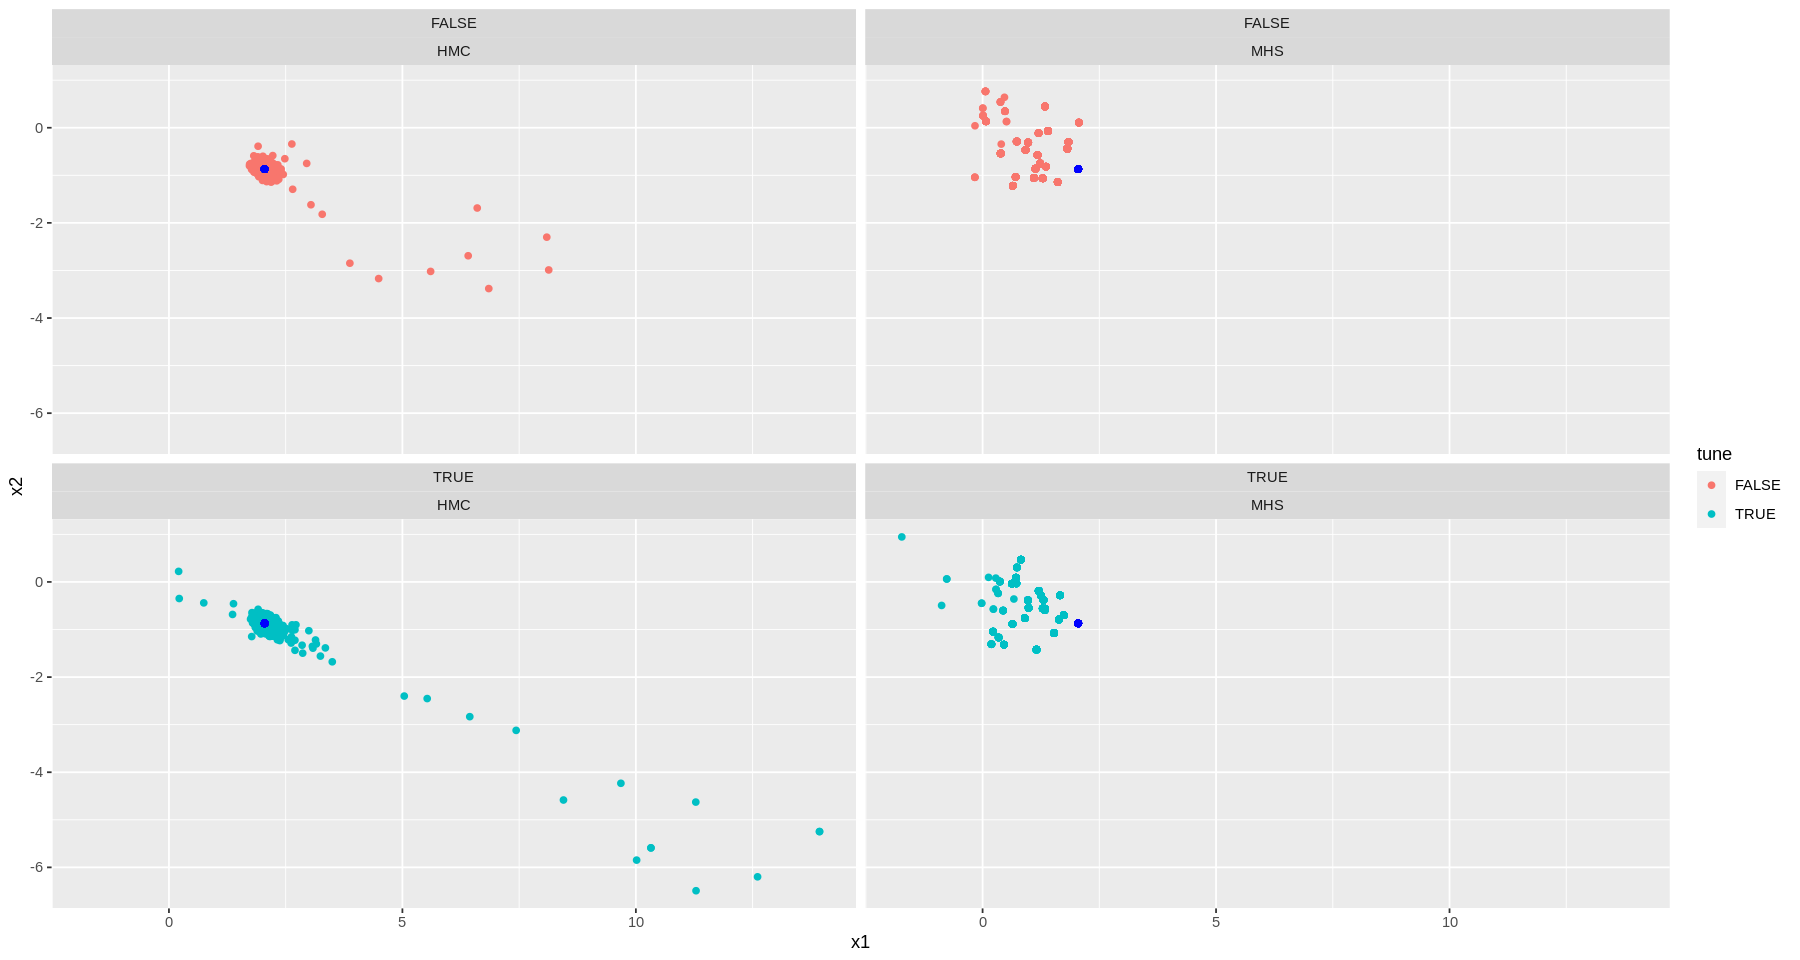

Saving 6.67 x 6.67 in image



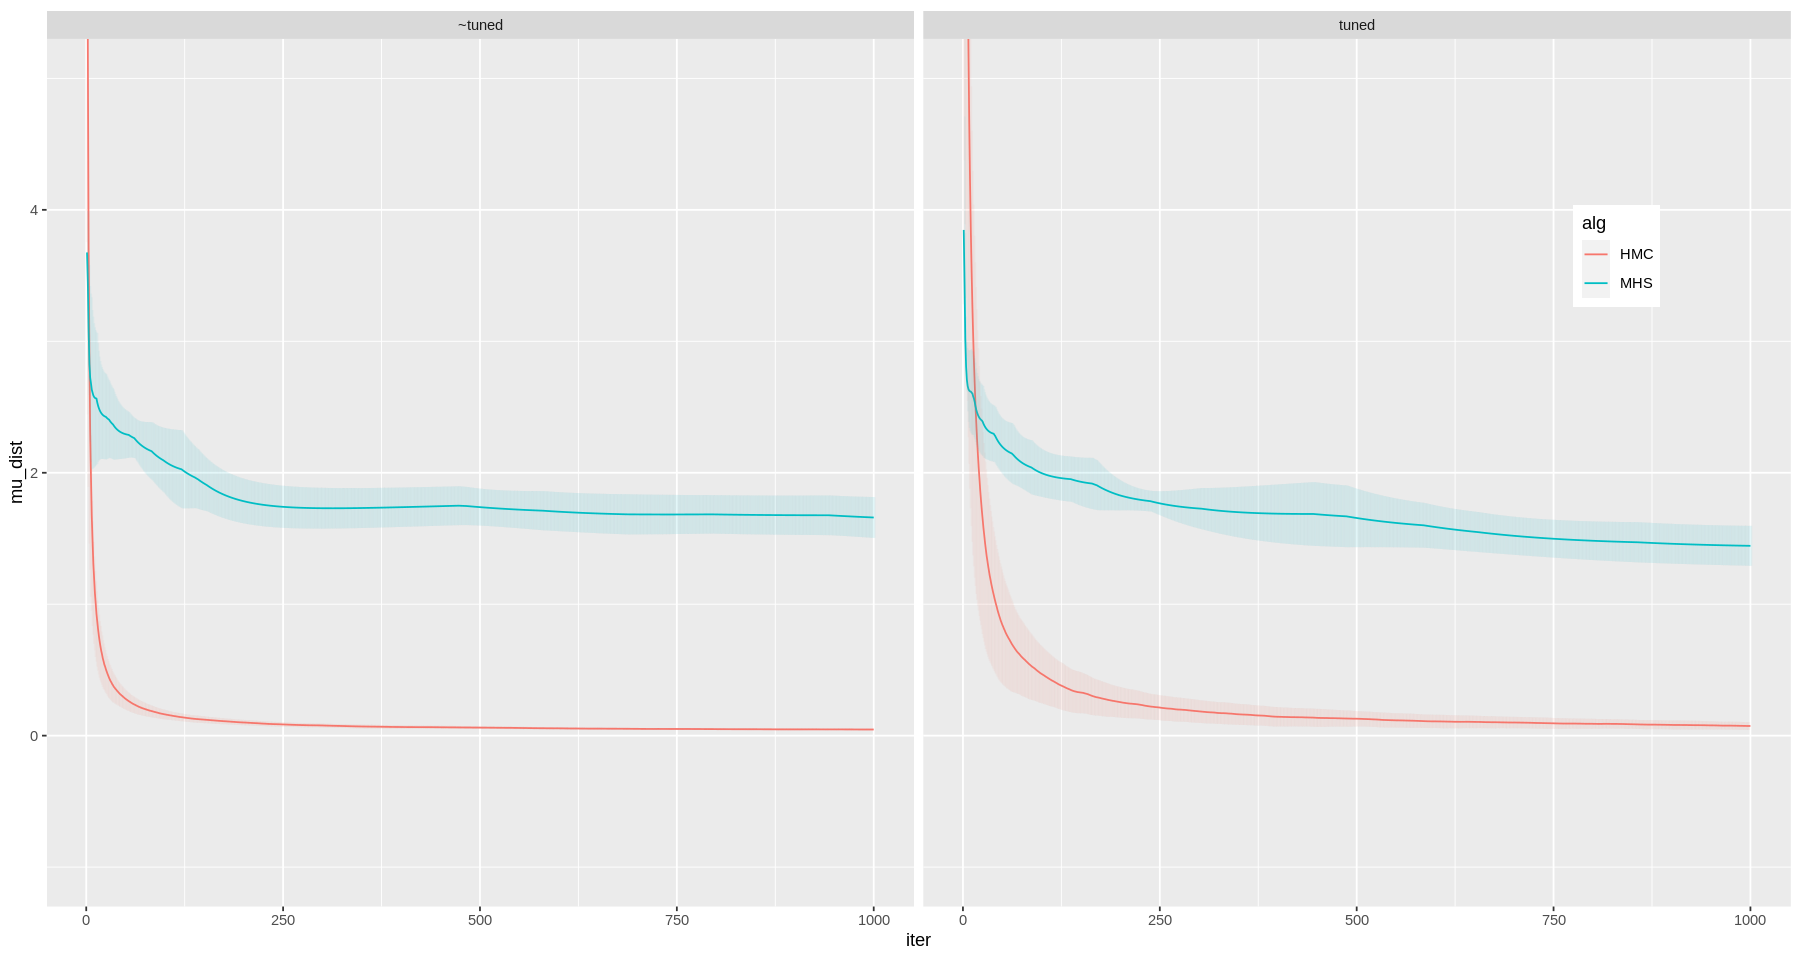

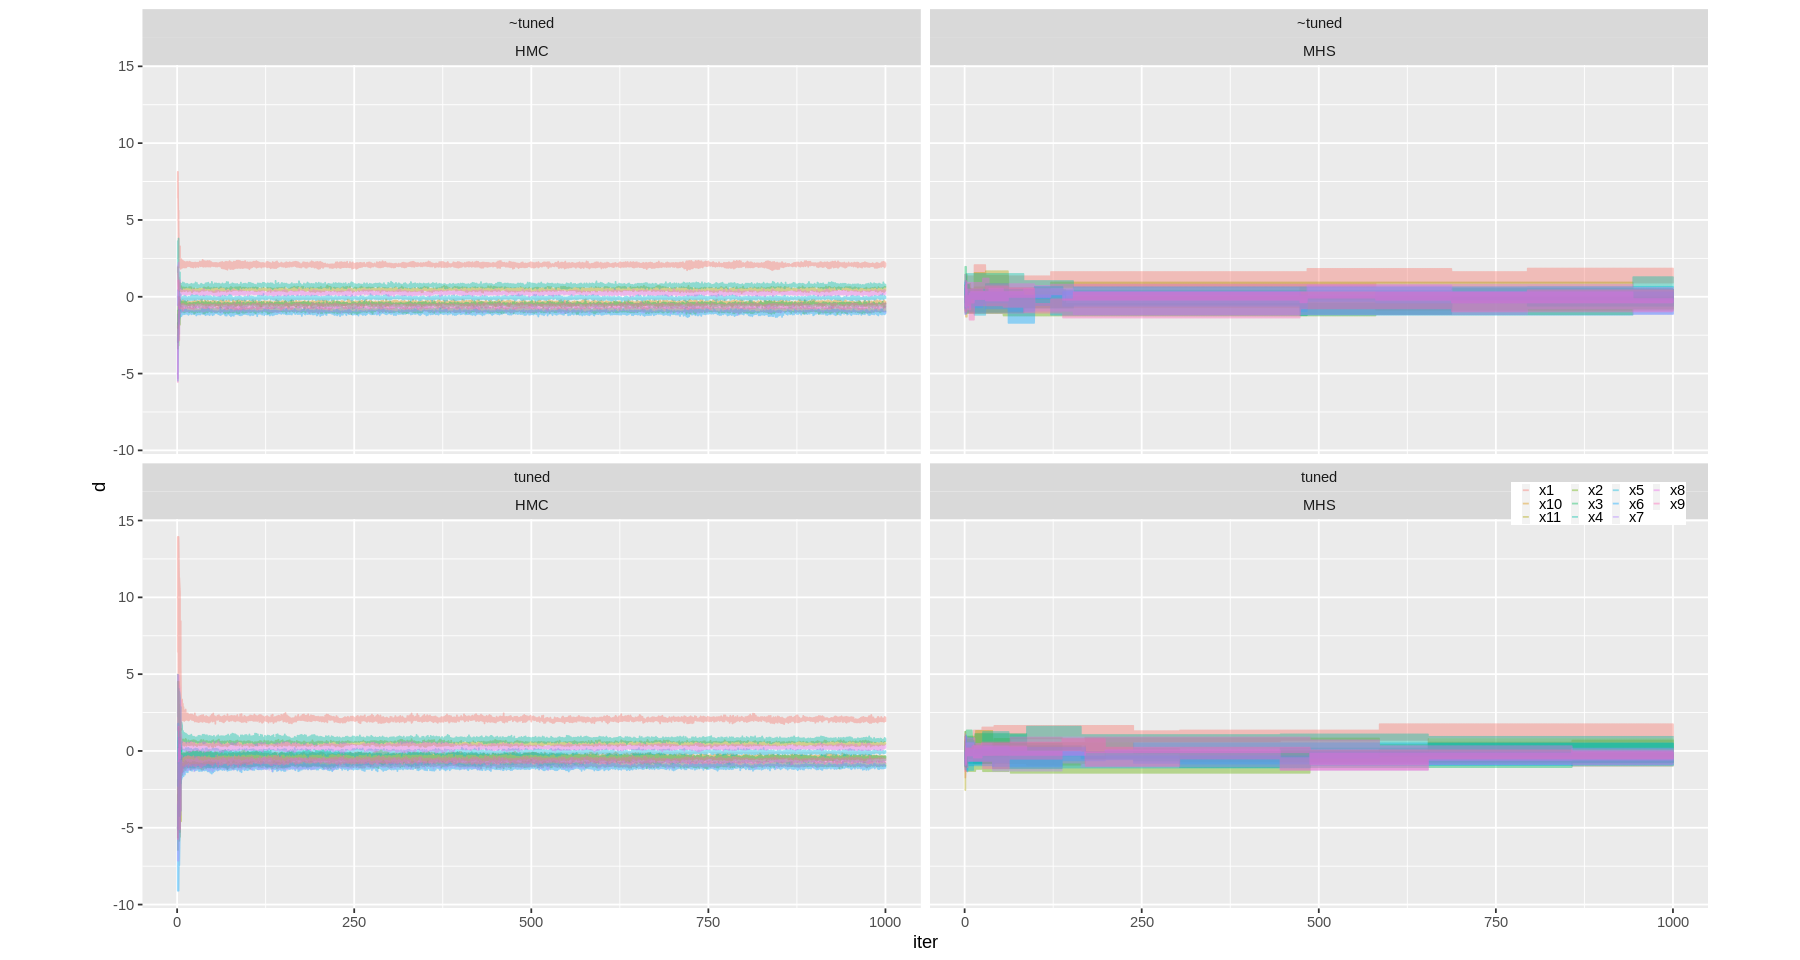

[1] "ESS"
  alg  tune        x1         x2         x3         x4         x5         x6
4 MHS  TRUE  12.79100  83.694922   8.597022   8.821026   7.653849   6.837857
2 MHS FALSE   8.30284   9.033531   8.653790  10.979013  14.685576  11.426458
1 HMC FALSE 645.31660 663.638647 824.703310 842.811738 189.918915 716.789661
3 HMC  TRUE 432.17057 566.470659 677.711134 661.441555 728.890615 548.040992
          x7         x8         x9         x10        x11         x1         x2
4   7.901454   16.18470   9.436594    8.206562   9.071556   5.123470 115.258159
2  59.104429   10.72623  16.419025   12.384998  28.990266   2.873593   2.690194
1 743.396493  840.61503 638.517093  578.005474 228.030207 346.306212 220.374141
3 577.860665 1595.27912 964.806436 1582.040518 647.415498 384.767752 418.718635
          x3         x4        x5          x6         x7          x8
4   4.752560   1.232776   1.09868   0.9313383   1.235456   20.402873
2   3.171474   5.588544  11.52967   8.8497313 110.374196    7.76354

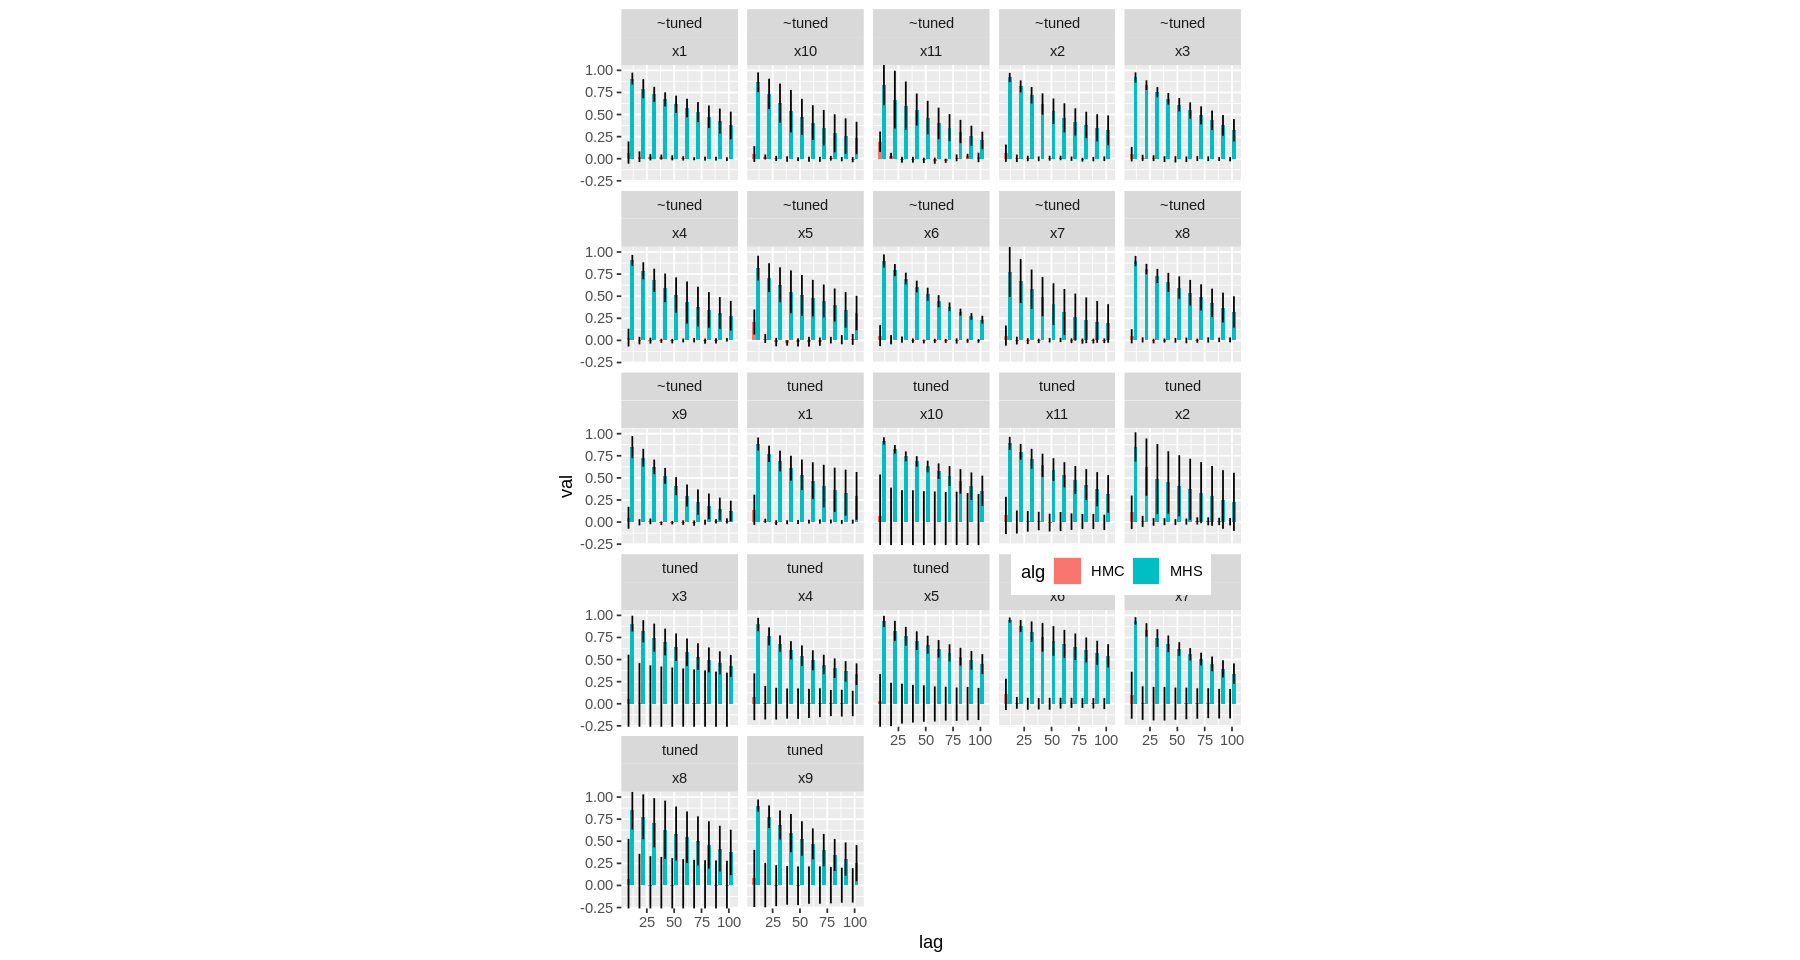

In [65]:
# specify parameters
binom.params <- list(

                    list("sampler"=MHS,
                      "niter"=1000,
                      "sigma"=diag(11),
                      "burnin"=FALSE,
                      "nburn"=0,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=0),
                     list("sampler"=MHS,
                      "niter"=1000,
                      "sigma"=diag(11),
                      "burnin"=TRUE,
                      "nburn"=mhs.min.param$nburn,
                      "epsilon"=0,
                      "nleaps"=0,
                      "const"=0),
                      list("sampler"=HMC,
                      "niter"=1000,
                      "sigma"=diag(11),
                      "burnin"=FALSE,
                      "nburn"=0,
                      "epsilon"=0.01,
                      "nleaps"=50,
                      "const"=0),
                     list("sampler"=HMC,
                      "niter"=1000,
                      "sigma"=diag(11),
                      "burnin"=TRUE,
                      "nburn"=hmc.min.param$nburn,
                      "epsilon"=hmc.min.param$epsilon,
                      "nleaps"=hmc.min.param$nleaps,
                      "const"=0))

df.binom <- generate_results(name = "binom_full", f = binom.prob, f.log = binom.prob.log, f.log.grad = binom.log.grad, dim = xdim, f.samplers = binom.params)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



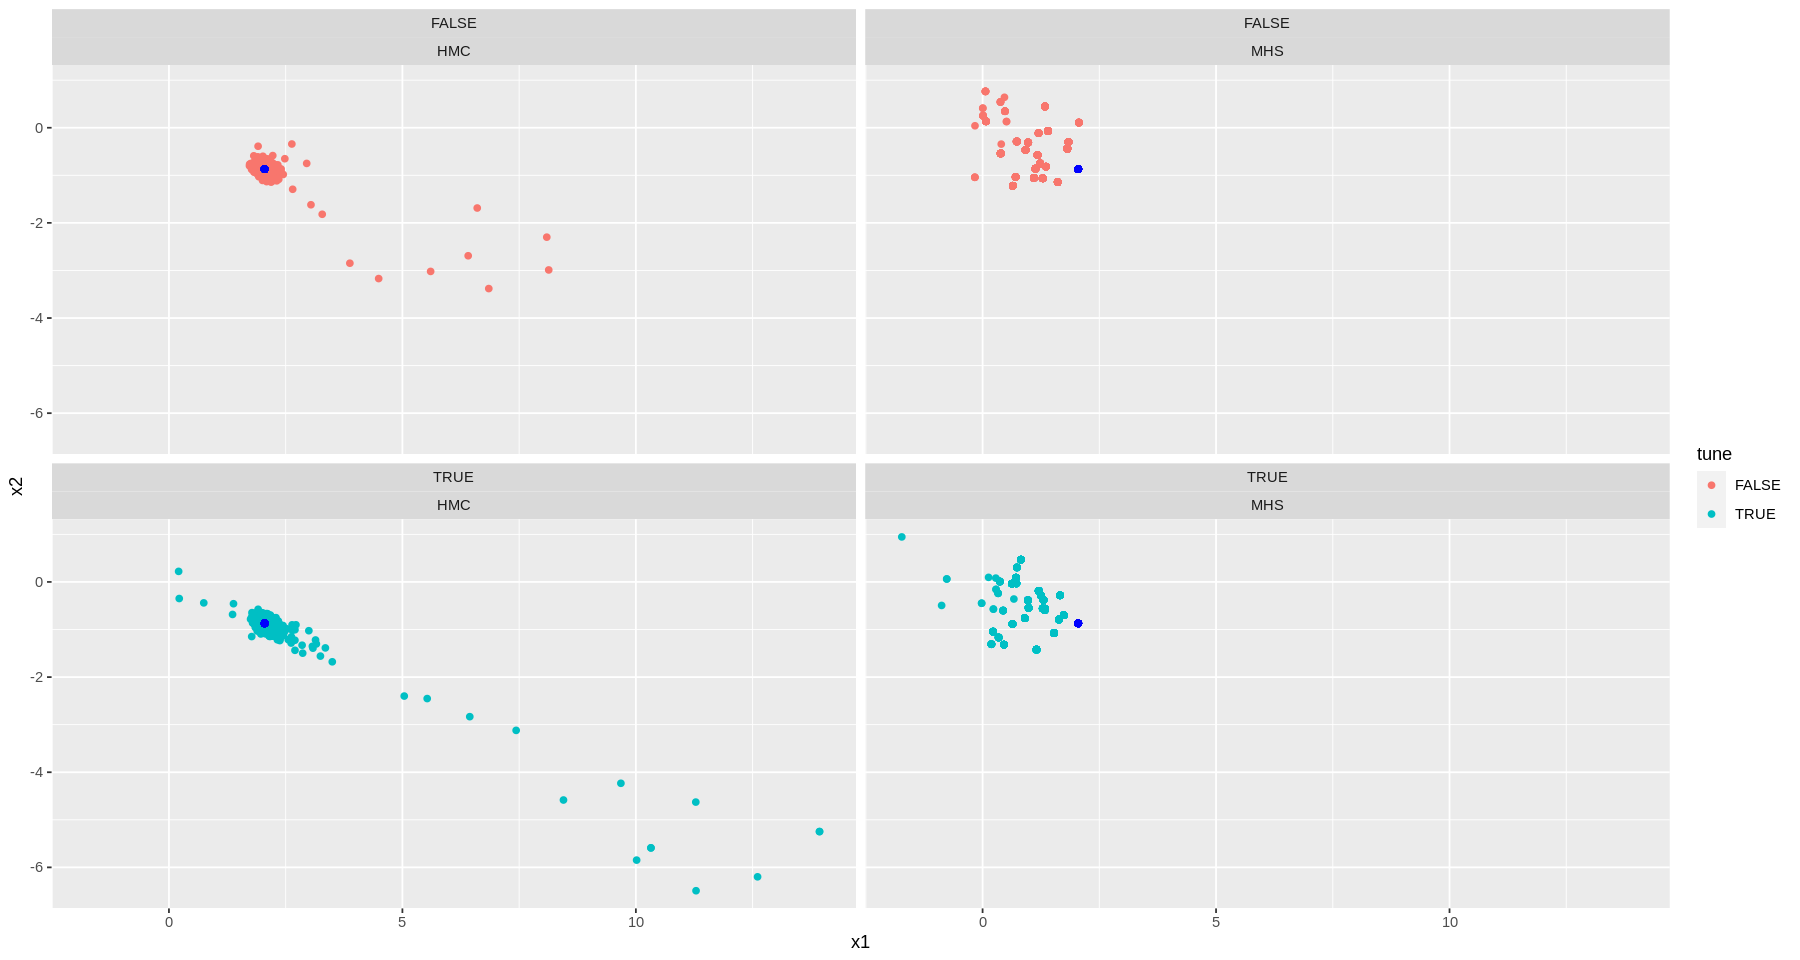

Saving 6.67 x 6.67 in image



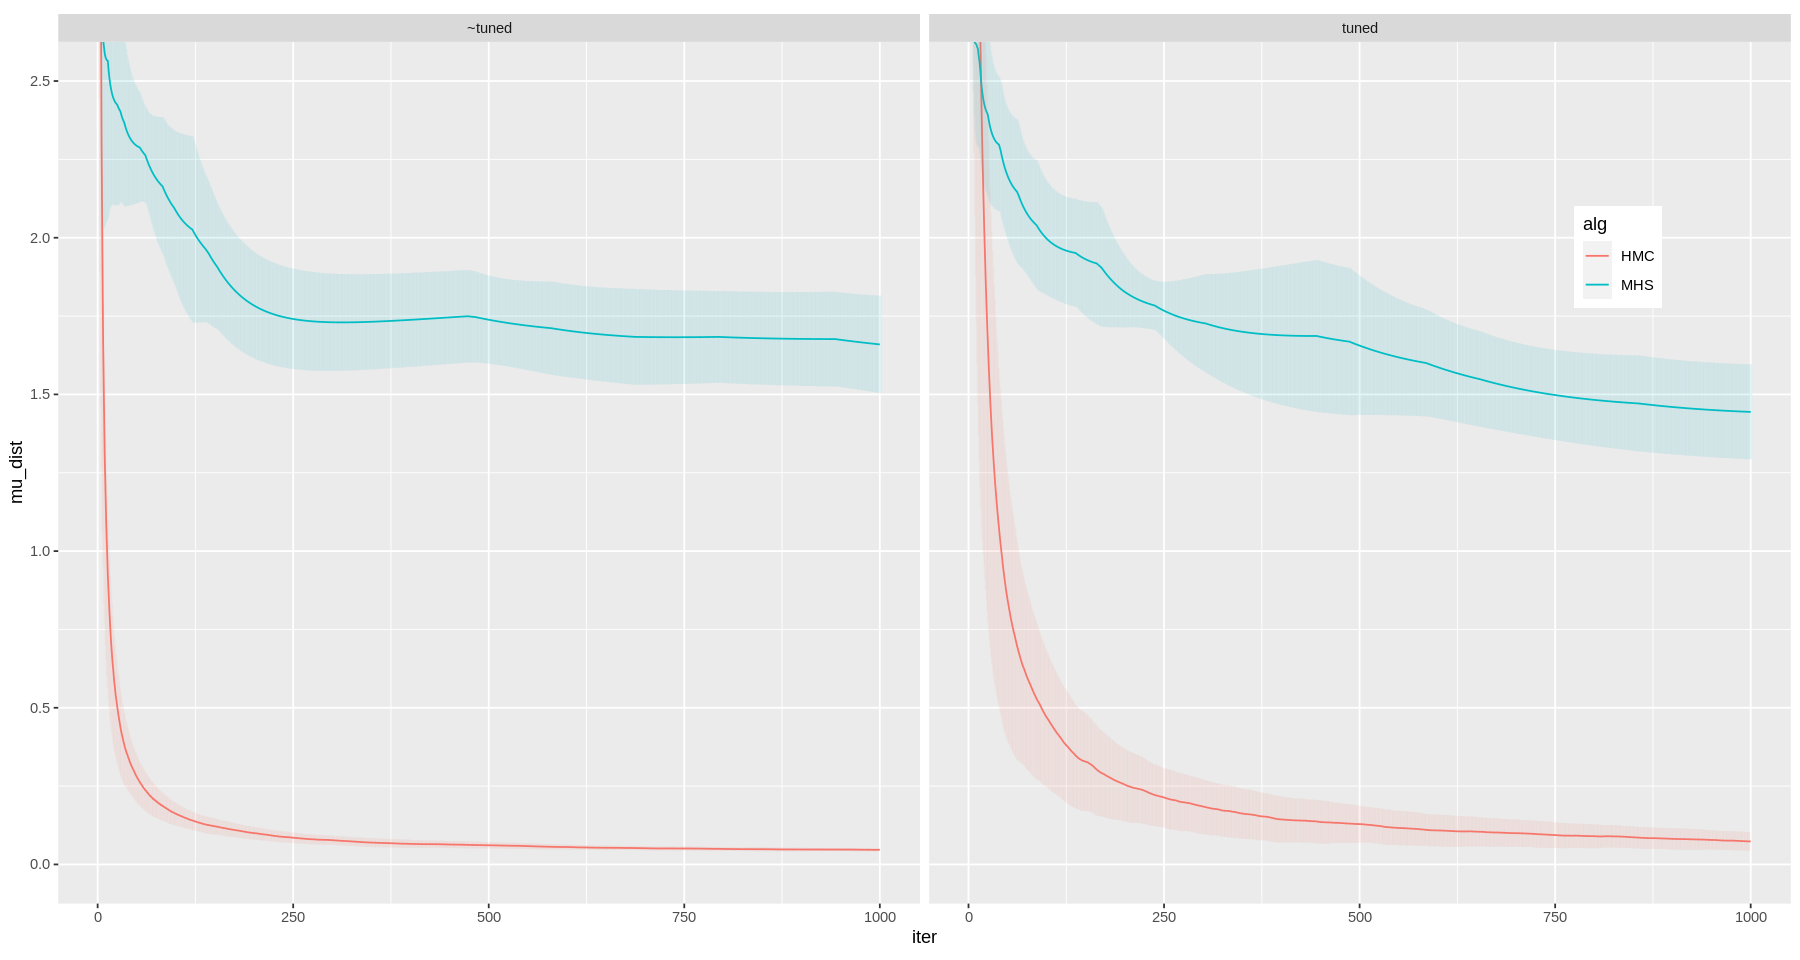

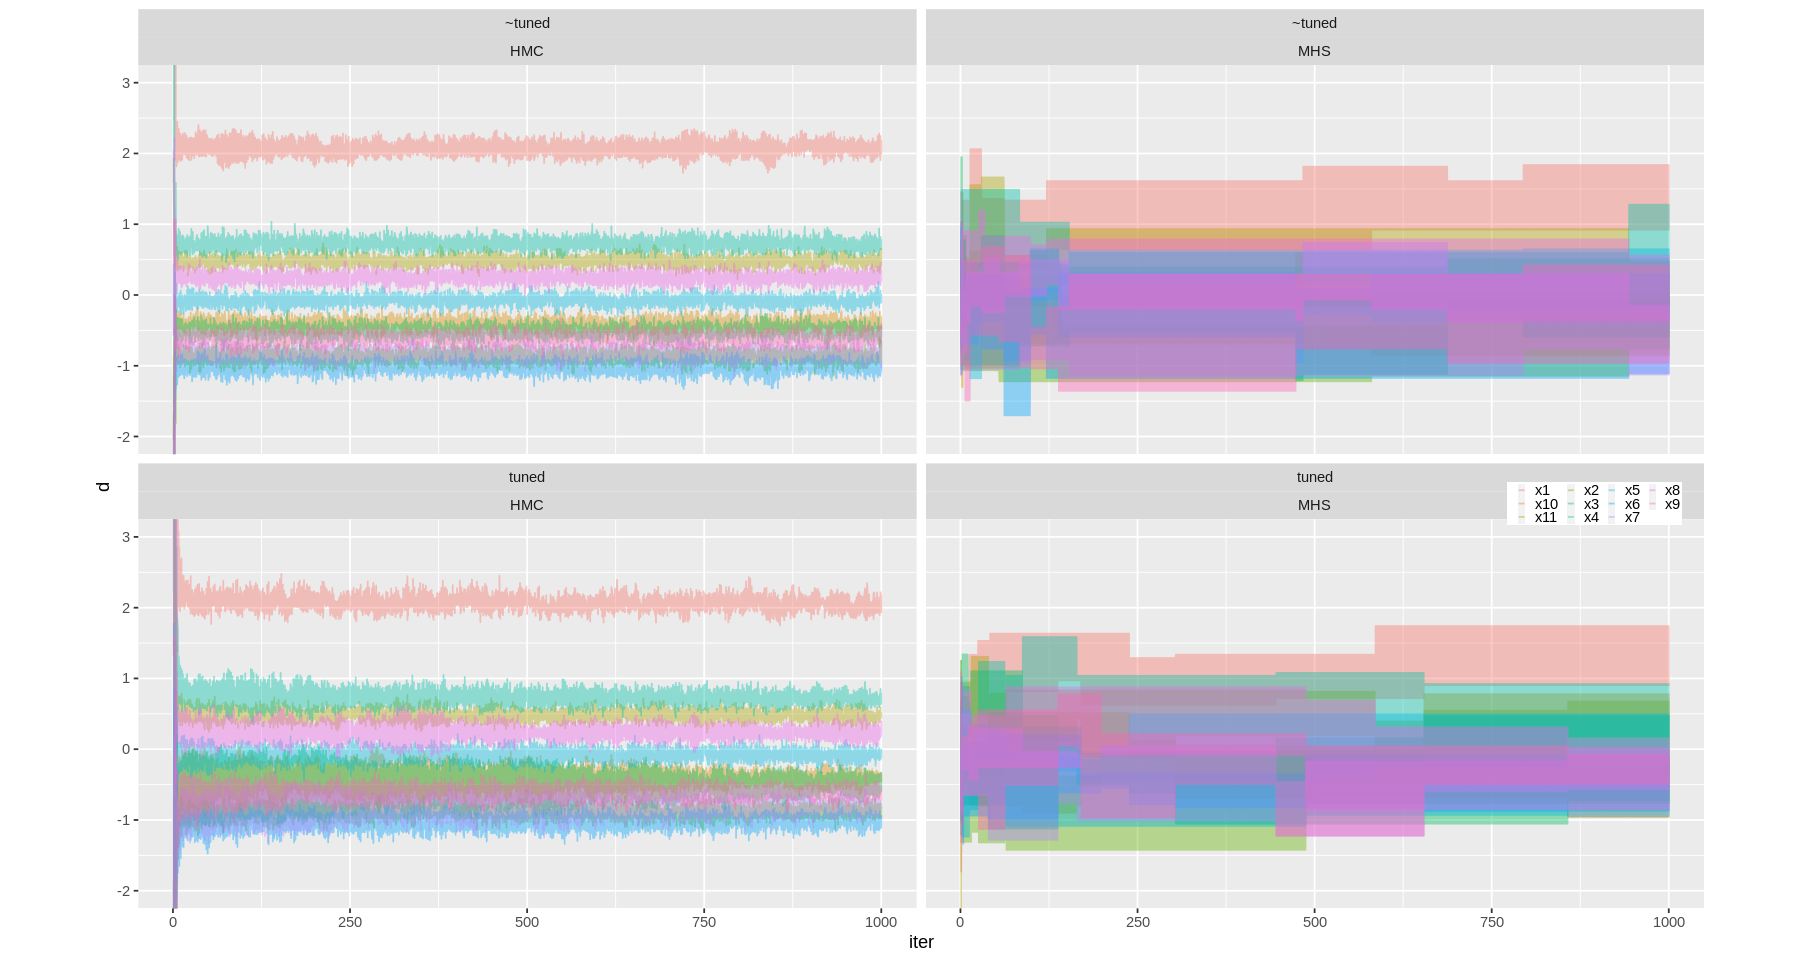

[1] "ESS"
  alg  tune        x1         x2         x3         x4         x5         x6
4 MHS  TRUE  12.79100  83.694922   8.597022   8.821026   7.653849   6.837857
2 MHS FALSE   8.30284   9.033531   8.653790  10.979013  14.685576  11.426458
1 HMC FALSE 645.31660 663.638647 824.703310 842.811738 189.918915 716.789661
3 HMC  TRUE 432.17057 566.470659 677.711134 661.441555 728.890615 548.040992
          x7         x8         x9         x10        x11         x1         x2
4   7.901454   16.18470   9.436594    8.206562   9.071556   5.123470 115.258159
2  59.104429   10.72623  16.419025   12.384998  28.990266   2.873593   2.690194
1 743.396493  840.61503 638.517093  578.005474 228.030207 346.306212 220.374141
3 577.860665 1595.27912 964.806436 1582.040518 647.415498 384.767752 418.718635
          x3         x4        x5          x6         x7          x8
4   4.752560   1.232776   1.09868   0.9313383   1.235456   20.402873
2   3.171474   5.588544  11.52967   8.8497313 110.374196    7.76354

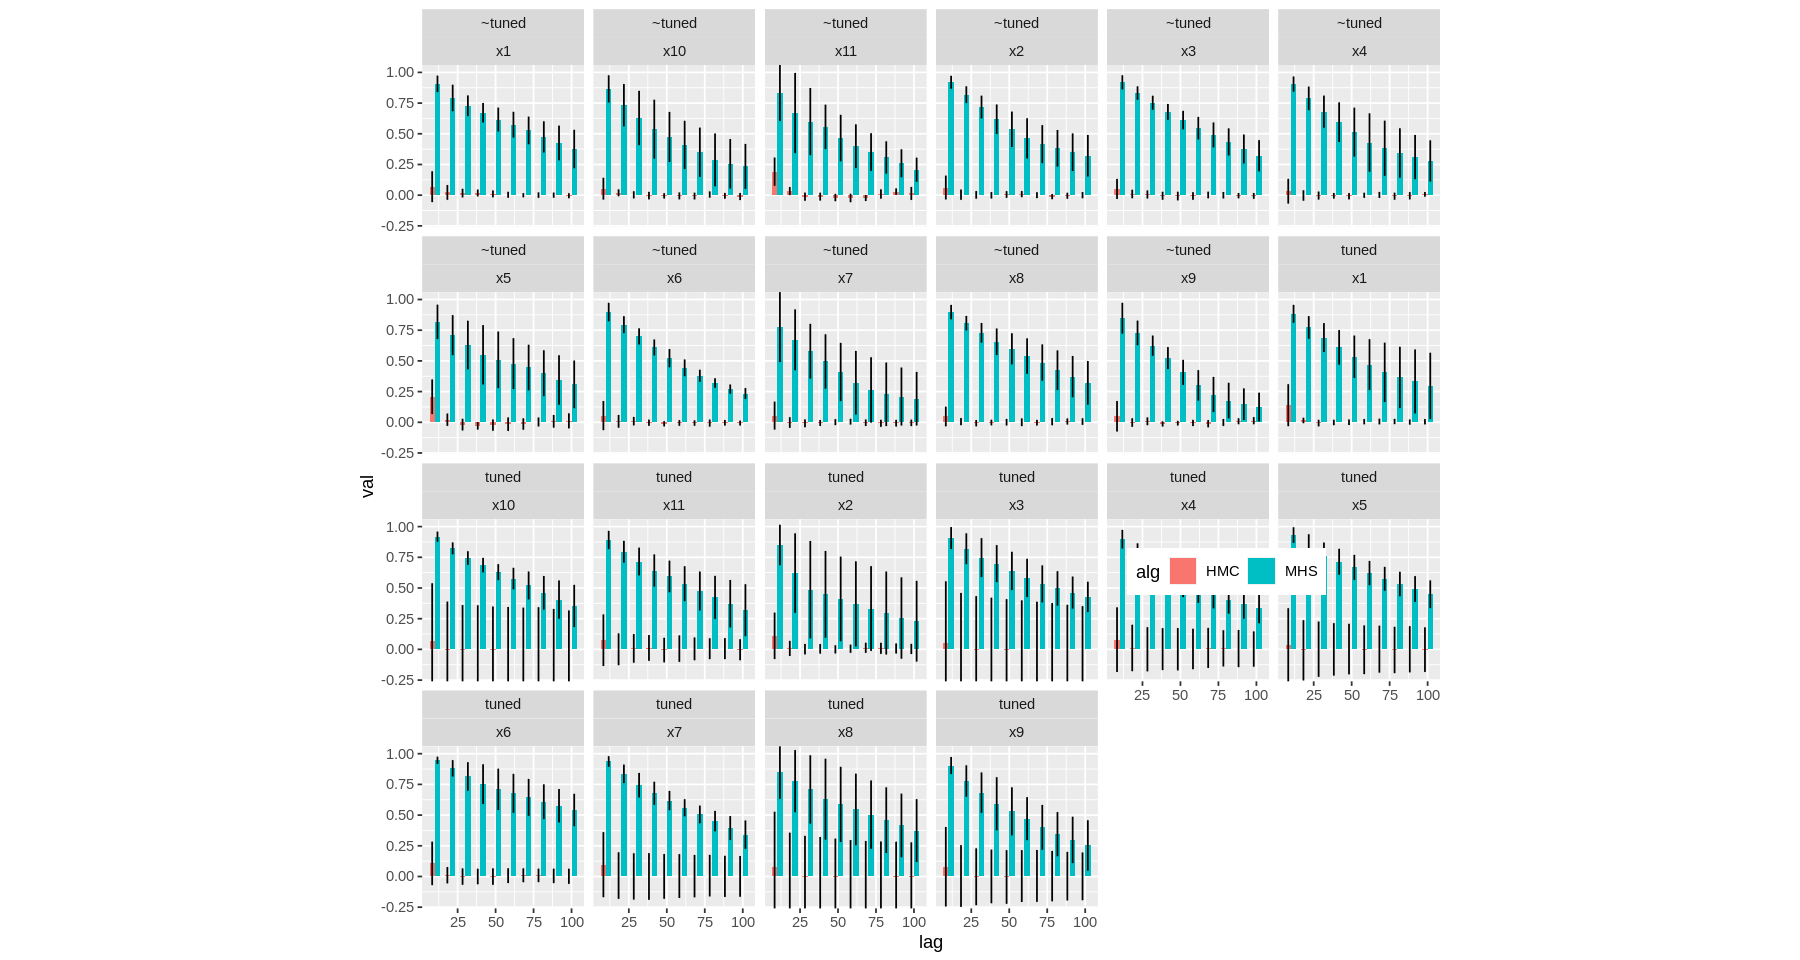

In [70]:
present_results(df.binom, "binom_full", keypoints = mu, bnds=list("cvg"=c(0, 2.5), "acf"=c(-0.2, 1), "tra"=c(-2,3)))

### 3. Discussion

TODO